In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from types import SimpleNamespace

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CPU


In [2]:
args = {
    'dataname': 'cifar10',
    'unlearn_method': 'retrain',
    'unlearn_type': 'set_random',
    # 'unlearn_type': 'one_class',
    'forget_class': 0,
    'forget_size': 500,
    'forget_class_ratio': 0.5,
    'model_numbs': 1,
    'EXACT_FLAG': True,
    'PRIVACY': False,
    'LOOP': 10,
    'metrics': ['p_Unleak', 'p_LiRA', 'p_update_LiRA', 'p_EMIA', 'p_RMIA', 'p_SimpleDiff', 'p_Dratio'],
    # 'metrics': ['p_Dratio'],
    'shadow_folder' : f'LIRA_checkpoints/shadow_models/',
    'activation_rmia': 'softmax',
    'SEED_init': 42,
    'records_folder': 'logs/new_records/',
}

# for dataname in ['cinic10', 'cifar100', 'cifar10', 'location', 'texas',  'purchase' ]:
# for dataname in ['cifar100']:
dataname = 'cifar100'
args.update({'dataname': dataname})
args.update({'unlearn_type': 'set_random'})
args = SimpleNamespace(**args)
print(args)
if args.unlearn_type == 'set_random':
    args.SUFFIX = dataname + '_' + args.unlearn_method + '_' + args.unlearn_type + '_' + str(args.forget_size)
    SEED_init = args.SEED_init
    RNG = torch.Generator()
    RNG.manual_seed(SEED_init)
    records_folder = args.records_folder + f'seed_{SEED_init}/'
    record_path = records_folder + f'{args.SUFFIX}_scores_{SEED_init}_{args.LOOP}_ref{args.model_numbs}.pth'
    print(f'load record from {record_path}')
    ALL_Scores = torch.load(record_path)
    print(f'load unlearn flags from {records_folder}{args.SUFFIX}_unlearn_flags_{SEED_init}_{args.LOOP}_ref{args.model_numbs}.pth')
    ALL_Unlearn_flags = torch.load(records_folder + f'{args.SUFFIX}_unlearn_flags_{SEED_init}_{args.LOOP}_ref{args.model_numbs}.pth')


namespace(dataname='cifar100', unlearn_method='retrain', unlearn_type='set_random', forget_class=0, forget_size=500, forget_class_ratio=0.5, model_numbs=1, EXACT_FLAG=True, PRIVACY=False, LOOP=10, metrics=['p_Unleak', 'p_LiRA', 'p_update_LiRA', 'p_EMIA', 'p_RMIA', 'p_SimpleDiff', 'p_Dratio'], shadow_folder='LIRA_checkpoints/shadow_models/', activation_rmia='softmax', SEED_init=42, records_folder='logs/new_records/')
load record from logs/new_records/seed_42/cifar100_retrain_set_random_500_scores_42_10_ref1.pth


/tmp/ipykernel_26500/4050706678.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ALL_Scores = torch.load(record_path)


load unlearn flags from logs/new_records/seed_42/cifar100_retrain_set_random_500_unlearn_flags_42_10_ref1.pth


/tmp/ipykernel_26500/4050706678.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ALL_Unlearn_flags = torch.load(records_folder + f'{args.SUFFIX}_unlearn_flags_{SEED_init

In [3]:
from sklearn.metrics import roc_curve, auc

def balanced_auc_extended_curve(labels, metric_diff_all, iterations=5000, verbose=True):
    """
    Calculate the AUC score and true positive rate at a low false positive rate for the non-membership inference attack.
    """
    # fpr, tpr, _ = roc_curve(labels, metric_diff_all)
    # auc_score = auc(fpr, tpr)
    # return fpr, tpr, auc_score

    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    sample_size = int(min(len(positive_indices), len(negative_indices)) * 0.8)

    interp_tpr_list, interp_tnr_list = [], []
    auc_list, acc_list = [], []

    fprs, tprs = [], []
    for _ in range(iterations):
        # Randomly sample indices from positive and negative classes to create a balanced dataset
        sampled_positive_indices = np.random.choice(positive_indices, size=sample_size, replace=True)
        sampled_negative_indices = np.random.choice(negative_indices, size=sample_size, replace=True)
        
        # Combine the resampled indices
        resampled_indices = np.concatenate((sampled_positive_indices, sampled_negative_indices))
        # Extract the corresponding labels and predictions
        resampled_labels = labels[resampled_indices]
        resampled_metric_diff_all = metric_diff_all[resampled_indices]    
        # Calculate the ROC curve for the balanced dataset
        fpr, tpr, _ = roc_curve(resampled_labels, resampled_metric_diff_all)
        fprs.append(fpr)
        tprs.append(tpr)

    max_len = max([len(fpr) for fpr in fprs])
    inserd_fpr = np.linspace(0, 1, max_len)
    interp_tprs = [np.interp(inserd_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    interp_tprs = np.stack(interp_tprs, axis=0)
    tpr = np.mean(interp_tprs, axis=0)
    fpr = inserd_fpr    
    auc_score = auc(fpr, tpr)

    # Define the specific FPR and FNR thresholds
    low_fpr_thresholds = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    low_fnr_thresholds = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

    # Calculate FNR and TNR
    fnr = 1 - tpr
    tnr = 1 - fpr

    # Interpolate TPR at specific FPR thresholds
    tpr_at_low_fpr = np.interp(low_fpr_thresholds, fpr, tpr)

    # Interpolate TNR at specific FNR thresholds
    # Since FNR decreases as TPR increases, we need to reverse the arrays for proper interpolation
    sorted_fnr_indices = np.argsort(fnr)
    fnr_sorted = fnr[sorted_fnr_indices]
    tnr_sorted = tnr[sorted_fnr_indices]

    tnr_at_low_fnr = np.interp(low_fnr_thresholds, fnr_sorted, tnr_sorted)
 
    return fpr, tpr, auc_score, low_fpr_thresholds, tpr_at_low_fpr, tnr_at_low_fnr

curves = {}
for loop in range(10):
    Scores = ALL_Scores[loop]
    Unlearn_flags = ALL_Unlearn_flags[loop]
    for key in Scores.keys():
        if key not in curves.keys():
            curves[key] = {'fpr': [], 'tpr': [], 'auc': []}

        desired_fpr, desired_tpr, _ = roc_curve(1-Unlearn_flags, 1-Scores[key])
        auc_score = auc(desired_fpr, desired_tpr)

        # Define the specific FPR and FNR thresholds
        low_fpr_thresholds = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
        low_fnr_thresholds = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

        # Calculate FNR and TNR
        fnr = 1 - desired_tpr
        tnr = 1 - desired_fpr

        # Interpolate TPR at specific FPR thresholds
        tpr_at_low_fpr = np.interp(low_fpr_thresholds, desired_fpr, desired_tpr)

        # Interpolate TNR at specific FNR thresholds
        # Since FNR decreases as TPR increases, we need to reverse the arrays for proper interpolation
        sorted_fnr_indices = np.argsort(fnr)
        fnr_sorted = fnr[sorted_fnr_indices]
        tnr_sorted = tnr[sorted_fnr_indices]

        tnr_at_low_fnr = np.interp(low_fnr_thresholds, fnr_sorted, tnr_sorted)

        curves[key]['fpr'].append(desired_fpr)
        curves[key]['tpr'].append(desired_tpr)
        curves[key]['auc'].append(auc_score)

        print(f'{key}: {auc_score}')
        print(f'{key}: {[np.round(x,4) for x in tpr_at_low_fpr]}')
        print(f'{key}: {[np.round(x,4) for x in tnr_at_low_fnr]}')


max_len = max([len(curves[key]['fpr'][loop]) for loop in range(10) for key in curves.keys()])

inserd_fpr = np.linspace(0, 1, max_len)
for key in curves.keys():
    for loop in range(10):
        curves[key]['tpr'][loop] = np.interp(inserd_fpr, curves[key]['fpr'][loop], curves[key]['tpr'][loop])

# average the tpr and auc
curves_ave = {}
for key in curves.keys():
    curves_ave[key] = {'fpr': [], 'tpr': [], 'auc': []}
    curves_ave[key]['fpr'] = inserd_fpr
    curves_ave[key]['tpr'] = np.mean(np.stack(curves[key]['tpr'], axis=0), axis=0)
    curves_ave[key]['auc'] = np.mean(np.stack(curves[key]['auc'], axis=0), axis=0)

p_Unleak: 0.8545645454237287
p_Unleak: [0.0019, 0.0019, 0.0019, 0.0127, 0.0711, 0.4183, 1.0]
p_Unleak: [0.0, 0.1189, 0.4858, 0.5687, 0.6328, 0.7152, 1.0]
p_LiRA: 0.7871335616949152
p_LiRA: [0.0028, 0.0028, 0.0028, 0.0169, 0.1784, 0.5415, 1.0]
p_LiRA: [0.0002, 0.0002, 0.0012, 0.004, 0.0331, 0.318, 1.0]
p_LiRA_Online: 0.8820567484745763
p_LiRA_Online: [0.0025, 0.0025, 0.0025, 0.0189, 0.2196, 0.6054, 1.0]
p_LiRA_Online: [0.114, 0.2193, 0.3095, 0.4088, 0.5215, 0.6629, 1.0]
p_update_LiRA: 0.619171419661017
p_update_LiRA: [0.0, 0.0, 0.0001, 0.0012, 0.0119, 0.1304, 1.0]
p_update_LiRA: [0.0, 0.0001, 0.0011, 0.0106, 0.1062, 0.3216, 1.0]
p_EMIA: 0.8142021593220339
p_EMIA: [0.0006, 0.0006, 0.0006, 0.0159, 0.2096, 0.5606, 1.0]
p_EMIA: [0.1846, 0.1924, 0.2109, 0.2344, 0.2607, 0.3639, 1.0]
p_EMIA_p: 0.8050612
p_EMIA_p: [0.0, 0.0, 0.0, 0.0002, 0.0036, 0.1591, 1.0]
p_EMIA_p: [0.1718, 0.4116, 0.4735, 0.5306, 0.6014, 0.6919, 1.0]
p_random: 0.5092342423728813
p_random: [0.0002, 0.0002, 0.0002, 0.0009, 0.

p_LiRA_Online: 0
p_LiRA: 1
p_Unleak: 2
p_EMIA: 3
p_RMIA_online: 4
p_RMIA: 5
p_IPapprox_simp_offline: 6
p_IPapprox_simp_online: 7
p_random: 8


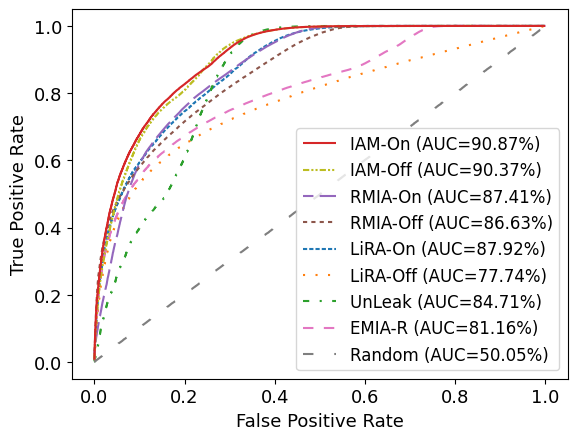

In [4]:
keys = ['p_LiRA_Online', 'p_LiRA', 'p_Unleak',  'p_EMIA',   'p_RMIA_online', 'p_RMIA', 'p_IPapprox_simp_offline', 'p_IPapprox_simp_online','p_random']
# Legend colors: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
custom_legend_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#9467bd', '#8c564b', '#bcbd22', '#d62728', '#7f7f7f']
custom_legend_order = ['IAM_online', 'IAM Offline', 'RMIA_online', 'LiRA Online', 'Unleak', 'RMIA', 'LiRA',  'EMIA',  'Random Guess']
legend_name = {'p_Unleak': 'UnLeak', 
              'p_LiRA': 'LiRA-Off', 
              'p_LiRA_Online': 'LiRA-On', 
              'p_EMIA': 'EMIA-R', 
              'p_RMIA': 'RMIA-Off', 
              'p_RMIA_online': 'RMIA-On', 
              'p_IPapprox_simp_offline': 'IAM-Off',
              'p_IPapprox_simp_online': 'IAM-On',
              'p_random': 'Random'}
plt.figure()
line_markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X']
line_styles = [
    (0, (2, 1)),                # densely dashed
    (0, (1, 5)),                # dotted
    (0, (3, 5, 1, 5)),          # dashdot
    (0, (5, 5)),               # long dash with offset
    (5, (10, 3)),               # long dash with offset
    (0, (2, 2)),                # dashed
    (0, (3, 1, 1, 1, 1, 1)),    # densely dashdotted
    (0, ()),                    # solid
    (0, (5, 10)),               # loosely dashed
]
middle_index_curves = int(len(inserd_fpr) * 0.2)
for i, key in enumerate(keys):
    if key in curves_ave.keys():
        print(f'{key}: {i}')
        marker_style = line_markers[i % len(line_markers)]
        linestyle = line_styles[i % len(line_styles)]
        # make the label is legend_name+auc_score
        # plt.plot(inserd_fpr, curves[key]['tpr'], label=f'{legend_name[key]} (auc={np.round(curves[key]["auc"],3):.3f})', lw=1.5, color=custom_legend_color[keys.index(key)])
        # if key == 'p_random':
        #     plt.plot(inserd_fpr, curves[key]['tpr'], label=f'{legend_name[key]}', 
        #             lw=1.5, color=custom_legend_color[keys.index(key)], linestyle=linestyle)
        # else:
        plt.plot(inserd_fpr, curves_ave[key]['tpr'], label=f'{legend_name[key]} (AUC={curves_ave[key]['auc']*100:.2f}%)', 
                    lw=1.5, color=custom_legend_color[keys.index(key)], linestyle=linestyle)

# random_guessing = np.random.randn(len(Scores[key]))
# desired_fpr, desired_tpr, auc_score,_,_,_ = balanced_auc_extended_curve(
#         1-Unlearn_flags, 1-random_guessing, verbose=False)
# plt.plot(desired_fpr, desired_fpr, label='Random Guess', linestyle=line_styles[-1], color=custom_legend_color[-1])
# print(f'random_guessing: {auc_score}')
handles, labels = plt.gca().get_legend_handles_labels()
custom_legend_order = [7, 6, 4, 5, 0, 1, 2, 3, 8]
plt.legend([handles[i] for i in custom_legend_order], [labels[i] for i in custom_legend_order], fontsize=12)
# sort the legend
# custom_handles = [line_handles[name] for name in custom_legend_order if name in line_handles]
# custom_labels = [name for name in custom_legend_order if name in line_handles]
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(f'figures/roc_curve_cifar100.pdf', bbox_inches='tight')
plt.show()


In [19]:
import re

def parse_metric_line(line):
    """Parse a single metric line into components."""
    parts = line.strip().split()    
    if len(parts) < 8:  # Check if line has enough components
        return None
    
    method_name = parts[0]
    metrics = {
        'auc': float(parts[1])
    }
    return method_name, metrics

def process_data_block(text):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    metrics_var_dict = {}
    lines = text.split('\n')
    for line in lines:
        if line.startswith('p_'):
            result = parse_metric_line(line)
            if result:
                method_name, metrics = result
                if method_name.startswith('p_') and method_name.endswith('_var'):
                    metrics_var_dict[method_name[:-4]] = metrics
                else:
                    metrics_dict[method_name] = metrics
    return metrics_dict, metrics_var_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    std_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')
    
    # First pass: Process all blocks and organize by dataset and unlearn_type
    for block in blocks[1:]:  # Skip first empty block
        # block start from  start_print and end with end_print
        # for each block, we cut the block until the first end_print
        block = block.split('end_print')[0]
        model_numbs_match = re.search(r"model_numbs=(\d+)", block)
        if not model_numbs_match:
            continue
        if int(model_numbs_match.group(1)) !=1:
            continue

        dataset_match = re.search(r"dataname='(\w+)'", block)
        if not dataset_match:
            continue
            
        dataset_name = dataset_match.group(1)
        if dataset_name not in datasets_combined:
            datasets_combined[dataset_name] = {}

        if dataset_name not in std_combined:
            std_combined[dataset_name] = {}
            
        unlearntype_match = re.search(r"unlearn_type='(\w+)'", block)
        if not unlearntype_match:
            continue
            
        unlearn_type = unlearntype_match.group(1)
        
        # Only process blocks we're interested in
        if unlearn_type == 'one_class':
            metrics, metrics_vars = process_data_block(block)
            for method, values in metrics.items():
                if method not in datasets_combined[dataset_name]:
                    datasets_combined[dataset_name][method] = {'one_class': values, 'class_percentage1': None, 'class_percentage5': None}
                else:
                    datasets_combined[dataset_name][method]['one_class'] = values

            for method, values in metrics_vars.items():
                if method not in std_combined[dataset_name]:
                    std_combined[dataset_name][method] = {'one_class': values, 'class_percentage1': None, 'class_percentage5': None}
                else:
                    std_combined[dataset_name][method]['one_class'] = values
            
        elif unlearn_type == 'class_percentage':
            ratio_match = re.search(r"forget_class_ratio=(\d+\.?\d*)", block)
            if ratio_match and ratio_match.group(1) == '0.1':
                metrics, metrics_vars = process_data_block(block)
                for method, values in metrics.items():
                    if method not in datasets_combined[dataset_name]:
                        datasets_combined[dataset_name][method] = {'one_class': None, 'class_percentage1': values, 'class_percentage5': None}
                    else:
                        datasets_combined[dataset_name][method]['class_percentage1'] = values

                for method, values in metrics_vars.items():
                    if method not in std_combined[dataset_name]:
                        std_combined[dataset_name][method] = {'one_class': None, 'class_percentage1': values, 'class_percentage5': None}
                    else:
                        std_combined[dataset_name][method]['class_percentage1'] = values

            # if ratio_match and ratio_match.group(1) == '0.3':
            #     metrics = process_data_block(block)
            #     for method, values in metrics.items():
            #         if method not in datasets_combined[dataset_name]:
            #             datasets_combined[dataset_name][method] = {'one_class': None, 'class_percentage1': None, 'class_percentage5': values}
            #         else:
            #             datasets_combined[dataset_name][method]['class_percentage5'] = values
        elif unlearn_type == 'set_random':
            metrics, metrics_vars = process_data_block(block)
            for method, values in metrics.items():
                if method not in datasets_combined[dataset_name]:
                    datasets_combined[dataset_name][method] = {'one_class': None, 'class_percentage1': None, 'set_random': values}
                else:
                    datasets_combined[dataset_name][method]['set_random'] = values

            for method, values in metrics_vars.items():
                if method not in std_combined[dataset_name]:
                    std_combined[dataset_name][method] = {'one_class': None, 'class_percentage1': None, 'set_random': values}
                else:
                    std_combined[dataset_name][method]['set_random'] = values                                                                

    
    # Second pass: Combine metrics
    final_datasets = {}
    final_std = {}
    for dataset_name, methods in datasets_combined.items():
        final_datasets[dataset_name] = {}
        for method_name, values in methods.items():
            one_class_auc = values['one_class']['auc'] if values['one_class'] else 0
            class_percentage1_auc = values['class_percentage1']['auc'] if values['class_percentage1'] else 0
            set_random_auc = values['set_random']['auc'] if values['set_random'] else 0
            final_datasets[dataset_name][method_name] = [set_random_auc, class_percentage1_auc, one_class_auc]

    for dataset_name, methods in std_combined.items():
        final_std[dataset_name] = {}
        for method_name, values in methods.items():
            one_class_auc = values['one_class']['auc'] if values['one_class'] else 0
            class_percentage1_auc = values['class_percentage1']['auc'] if values['class_percentage1'] else 0
            set_random_auc = values['set_random']['auc'] if values['set_random'] else 0
            final_std[dataset_name][method_name] = [set_random_auc, class_percentage1_auc, one_class_auc]
            
    return final_datasets, final_std

def create_latex_table(datasets, datasets_std, method_mapping, groups, CLASS_LEVEL=False):
    """Create LaTeX table from processed data with combined metrics."""

    if not CLASS_LEVEL:
        latex_lines = [
            "\\begin{table*}[htbp]",
            "\\begin{center}",
            "\\begin{threeparttable}",
            "\\centering",
            "\\caption{AUC (\\%) of measurement methods on two BinUI tasks}",
            "\\begin{tabular}{@{\\extracolsep{\\fill}}c@{\\hspace{0.23em}}p{4.7em}@{\\hspace{0.25em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}}",
            "\\hline\\hline",
            "& \\multirow{2}{*}{\\textbf{Method}}  & \\multicolumn{2}{c}{\\textbf{CIFAR-10}} & \\multicolumn{2}{c}{\\textbf{CIFAR-100}} & \\multicolumn{2}{c}{\\textbf{CINIC-10}} & \\multicolumn{2}{c}{\\textbf{Purchase}}\\\\", 
            "\\cmidrule(lr){3-10} ",
            "& & Random & 10\\% & Random & 10\\%  & Random & 10\\%  & Random & 10\\% \\\\",
            "\\hline\\hline"
        ]
    else:
        latex_lines = [
            "\\begin{table*}[htbp]",
            "\\begin{center}",
            "\\begin{threeparttable}",
            "\\centering",
            "\\caption{AUC (\\%) of measurement methods on class-level BinUI tasks}",
            "\\begin{tabular}{@{\\extracolsep{\\fill}}c@{\\hspace{1em}}p{4.7em}>{\\centering\\arraybackslash}p{5.3em}>{\\centering\\arraybackslash}p{5.3em}>{\\centering\\arraybackslash}p{5.3em}>{\\centering\\arraybackslash}p{5.3em}}",
            "\\hline\\hline",
            "& {\\textbf{Method}}  & \\multicolumn{1}{c}{\\textbf{CIFAR-10}} & \\multicolumn{1}{c}{\\textbf{CIFAR-100}} & \\multicolumn{1}{c}{\\textbf{CINIC-10}} & \\multicolumn{1}{c}{\\textbf{Purchase}}\\\\", 
            "\\hline\\hline"
        ]        
    
    # Track best AUC for each dataset
    best_aucs0_off = {dataset: max(float(data[method][0]) 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}

    best_aucs1_off = {dataset: max(data[method][1] 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}
    
    best_aucs2_off = {dataset: max(data[method][2] 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}
    
    best_aucs0_ol = {dataset: max(float(data[method][0]) 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}

    best_aucs1_ol = {dataset: max(data[method][1] 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}
    
    best_aucs2_ol = {dataset: max(data[method][2] 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}
    

    # Process each group
    for group_name, methods in groups.items():
        # Add group header
        latex_lines.append(f"\\multirow{{{len(methods)}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{\\textbf{{{group_name}}}}}}} ")
        
        # Process each method in group
        for method_key in methods:
            line = f"& {method_mapping[method_key]}"
            
            # Add data for each dataset
            for dataset in ['cifar10', 'cifar100', 'cinic10', 'purchase']:
                if dataset not in datasets or method_key not in datasets[dataset]:
                    line += " & -"
                    continue
                    
                data = datasets[dataset][method_key]
                std = datasets_std[dataset][method_key]
                if not CLASS_LEVEL:
                    auc_str0 = f"{data[0]*100:.2f} \\!$\\pm$ \\!{std[0]*100:.2f}"
                    auc_str1 = f"{data[1]*100:.2f} \\!$\\pm$ \\!{std[1]*100:.2f}"
                else:
                    auc_str2 = f"{data[2]*100:.2f} \\!$\\pm$ \\!{std[2]*100:.2f}"
                
                if group_name == 'Offline':
                    # Bold if this is the best AUC
                    if not CLASS_LEVEL:
                        if abs(data[0] - best_aucs0_off[dataset]) < 1e-6:
                            auc_str0 = f"\\textbf{{{auc_str0}}}"
                        if abs(data[1] - best_aucs1_off[dataset]) < 1e-6:
                            auc_str1 = f"\\textbf{{{auc_str1}}}"
                    else:
                        if abs(data[2] - best_aucs2_off[dataset]) < 1e-6:
                            auc_str2 = f"\\textbf{{{auc_str2}}}"
                else:
                    # Bold if this is the best AUC
                    if not CLASS_LEVEL:
                        if abs(data[0] - best_aucs0_ol[dataset]) < 1e-6:
                            auc_str0 = f"\\textbf{{{auc_str0}}}"
                        if abs(data[1] - best_aucs1_ol[dataset]) < 1e-6:
                            auc_str1 = f"\\textbf{{{auc_str1}}}"
                    else:
                        if abs(data[2] - best_aucs2_ol[dataset]) < 1e-6:
                            auc_str2 = f"\\textbf{{{auc_str2}}}"
                
                if not CLASS_LEVEL:
                    line += f" & {auc_str0} & {auc_str1}"
                else:
                    line += f"& {auc_str2}"
            
            line += " \\\\"
            latex_lines.append(line)
        latex_lines.append(f'\\hline')

    # Add table footer
    if not CLASS_LEVEL:
        latex_lines.extend([
            "\\hline",
            "\\end{tabular}",
            "\\label{tab:method_comparison2}",
            "\\end{threeparttable}",
            "\\end{center}",
            "\\end{table*}"
        ])
    else:
        latex_lines.extend([
            "\\hline",
            "\\end{tabular}",
            "\\label{tab:method_comparison_class}",
            "\\end{threeparttable}",
            "\\end{center}",
            "\\end{table*}"
        ])
    
    return "\n".join(latex_lines)

# Define method mappings and groups
method_mapping = {
    'p_random': 'Random',
    'p_LiRA': 'LiRA-Off',
    'p_EMIA': 'EMIA-R',
    'p_EMIA_p': 'EMIA-P',
    'p_RMIA': 'RMIA-Off',
    'p_update_LiRA': 'UpdateAtk',
    'p_Unleak': 'UnLeak',
    'p_LiRA_Online': 'LiRA-On',
    'p_RMIA_online': 'RMIA-On',
    'p_IPapprox_simp_offline': 'IAM-Off',
    'p_IPapprox_simp_online': 'IAM-On',
}

groups = {
    'Offline': ['p_random', 'p_EMIA_p', 'p_EMIA', 'p_LiRA',  'p_RMIA', 'p_IPapprox_simp_offline'],
    'Online': ['p_update_LiRA', 'p_Unleak', 'p_LiRA_Online', 'p_RMIA_online', 'p_IPapprox_simp_online']
}

# scan all files under logs/new_records/refnum end with .out, combine their content into logs/post_test/latex_input_refnum_all.txt
import os
import re

def combine_files(log_dir, output_file):
    """Combine contents of all .out files in log_dir into output_file."""
    with open(output_file, 'w') as out_f:
        for file in os.listdir(log_dir):
            if file.endswith('.out'):
                with open(os.path.join(log_dir, file), 'r') as in_f:
                    out_f.write(in_f.read())
                    out_f.write('\n\n')

# Combine all .out files in logs/new_records/refnum into a single file
output_file = 'logs/new_records/post_test/latex_input_refnum_all.txt'
log_dir = 'logs/new_records/refnum'
combine_files(log_dir, output_file)
with open(output_file, 'a') as out_f:
    with open('logs/new_records/all_retrain-all_retrain-38859753-slurm.out', 'r') as in_f:
        out_f.write(in_f.read())
        out_f.write('\n\n')

with open(output_file, 'r') as f:
    content = f.read()

datasets, datasets_std = extract_datasets(content)
latex_table = create_latex_table(datasets, datasets_std, method_mapping, groups)
print(latex_table)
class_latex_table = create_latex_table(datasets, datasets_std, method_mapping, groups, CLASS_LEVEL=True)
print(class_latex_table)

\begin{table*}[htbp]
\begin{center}
\begin{threeparttable}
\centering
\caption{AUC (\%) of measurement methods on two BinUI tasks}
\begin{tabular}{@{\extracolsep{\fill}}c@{\hspace{0.23em}}p{4.7em}@{\hspace{0.25em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}}
\hline\hline
& \multirow{2}{*}{\textbf{Method}}  & \multicolumn{2}{c}{\textbf{CIFAR-10}} & \multicolumn{2}{c}{\textbf{CIFAR-100}} & \multicolumn{2}{c}{\textbf{CINIC-10}} & \multicolumn{2}{c}{\textbf{Purchase}}\\
\cmidrule(lr){3-10} 
& & Random & 10\% & Random & 10\%  & Random & 10\%  & Random & 10\% \\
\hline\hline
\multirow{6}{*}{\rotatebox[origin=c]{90}{\t

In [30]:
import re

def parse_metric_line(line):
    """Parse a single metric line into components."""
    parts = line.strip().split()    
    if len(parts) < 8:  # Check if line has enough components
        return None
    
    method_name = parts[0]
    metrics = {
        'auc': float(parts[1])
    }
    return method_name, metrics

def process_data_block(text):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    metrics_var_dict = {}
    lines = text.split('\n')
    for line in lines:
        if line.startswith('p_'):
            result = parse_metric_line(line)
            if result:
                method_name, metrics = result
                if method_name.startswith('p_') and method_name.endswith('_var'):
                    metrics_var_dict[method_name[:-4]] = metrics
                else:
                    metrics_dict[method_name] = metrics
    return metrics_dict, metrics_var_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    std_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')
    
    # First pass: Process all blocks and organize by dataset and unlearn_type
    for block in blocks[1:]:  # Skip first empty block
        # block start from  start_print and end with end_print
        # for each block, we cut the block until the first end_print
        block = block.split('end_print')[0]
        model_numbs_match = re.search(r"model_numbs=(\d+)", block)
        if not model_numbs_match:
            continue
        if int(model_numbs_match.group(1)) !=1:
            continue

        dataset_match = re.search(r"dataname='(\w+)'", block)
        if not dataset_match:
            continue
            
        dataset_name = dataset_match.group(1)
        if dataset_name not in datasets_combined:
            datasets_combined[dataset_name] = {}

        if dataset_name not in std_combined:
            std_combined[dataset_name] = {}
            
        unlearntype_match = re.search(r"unlearn_type='(\w+)'", block)
        if not unlearntype_match:
            continue
            
        unlearn_type = unlearntype_match.group(1)
        
        # Only process blocks we're interested in
        if unlearn_type == 'set_random':
            metrics, metrics_vars = process_data_block(block)
            for method, values in metrics.items():
                if method not in datasets_combined[dataset_name]:
                    datasets_combined[dataset_name][method] = {'set_random': values}
                else:
                    datasets_combined[dataset_name][method]['set_random'] = values

            for method, values in metrics_vars.items():
                if method not in std_combined[dataset_name]:
                    std_combined[dataset_name][method] = {'set_random': values}
                else:
                    std_combined[dataset_name][method]['set_random'] = values                                                                

    
    # Second pass: Combine metrics
    final_datasets = {}
    final_std = {}
    for dataset_name, methods in datasets_combined.items():
        final_datasets[dataset_name] = {}
        for method_name, values in methods.items():
            set_random_auc = values['set_random']['auc'] if values['set_random'] else 0
            final_datasets[dataset_name][method_name] = [set_random_auc]

    for dataset_name, methods in std_combined.items():
        final_std[dataset_name] = {}
        for method_name, values in methods.items():
            set_random_auc = values['set_random']['auc'] if values['set_random'] else 0
            final_std[dataset_name][method_name] = [set_random_auc]
            
    return final_datasets, final_std

def create_latex_table(datasets, datasets_std, method_mapping, groups, CLASS_LEVEL=False):
    """Create LaTeX table from processed data with combined metrics."""

    latex_lines = [
        "\\begin{table}[htbp]",
        "\\begin{center}",
        "\\begin{threeparttable}",
        "\\centering",
        "\\caption{Scoring functions}",
        "\\begin{tabular}{@{\\extracolsep{\\fill}}c@{\\hspace{0.23em}}p{4.7em}@{\\hspace{0.25em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}c@{\\hspace{0.23em}}p{4.7em}@{\\hspace{0.25em}}>{\\centering\\arraybackslash}p{5.3em}@{\\hspace{0.3em}}}",
        "\\hline\\hline",
        "& methods & AUC & & methods & AUC \\\\",
        "\\hline\\hline"
    ]      
    
    # Track best AUC for each dataset
    best_aucs0_off = {dataset: max(float(data[method][0]) 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}
    
    best_aucs0_ol = {dataset: max(float(data[method][0]) 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}
    

    # Process each group
    INIT = 2
    for method_key in groups['Offline']:
        group_name = 'Offline'
        # Add group header
        if INIT>0:
            latex_lines.append(f"\\multirow{{{len(groups[group_name])}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{\\textbf{{{group_name}}}}}}} ")
            INIT -= 1
            line = f"& {method_mapping[method_key]}"
        else:
            line = f"& {method_mapping[method_key]}"
        
        # Add data for each dataset
        dataset = 'cifar100'            
        data = datasets[dataset][method_key]
        std = datasets_std[dataset][method_key]
        auc_str0 = f"{data[0]*100:.2f} \\!$\\pm$ \\!{std[0]*100:.2f}"
        
        # Bold if this is the best AUC
        if abs(data[0] - best_aucs0_off[dataset]) < 1e-6:
            auc_str0 = f"\\textbf{{{auc_str0}}}"

        line += f" & {auc_str0} "
        
        group_name = 'Online'
        method_key = method_key.replace('of', 'ol') if 'pure' not in method_key else method_key
        # Add group header
        if INIT>0:
            line += f"& \\multirow{{{len(groups[group_name])}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{\\textbf{{{group_name}}}}}}}"
            INIT -= 1
            line += f"& {method_mapping[method_key]}"
        else:
            line += f"& & {method_mapping[method_key]}"
        
        # Add data for each dataset
        dataset = 'cifar100'            
        data = datasets[dataset][method_key]
        std = datasets_std[dataset][method_key]
        auc_str0 = f"{data[0]*100:.2f} \\!$\\pm$ \\!{std[0]*100:.2f}"
        
        # Bold if this is the best AUC
        if abs(data[0] - best_aucs0_ol[dataset]) < 1e-6:
            auc_str0 = f"\\textbf{{{auc_str0}}}"

        line += f" & {auc_str0} "

        line += " \\\\"
        latex_lines.append(line)


    # Add table footer
    latex_lines.extend([
        "\\hline",
        "\\hline",
        "\\end{tabular}",
        "\\label{tab:method_scoring}",
        "\\end{threeparttable}",
        "\\end{center}",
        "\\end{table}"
    ])

    
    return "\n".join(latex_lines)

# Define method mappings and groups
method_mapping = {
    'p_proby_of_pure': 'Prob',
    'p_lossy_of_pure': 'Loss',
    'p_proby_ol_pure': 'Prob',
    'p_lossy_ol_pure': 'Loss',
    'p_IPapprox_proby_of_ecdf': 'ECDF-Off',
    'p_IPapprox_proby_of_kde': 'KDE-Off',
    'p_IPapprox_proby_of_beta': 'Bayes-Off',
    'p_IPapprox_carlogi_of_norm': 'Gauss-Off',
    'p_IPapprox_IAM_of_gumbel': 'Gumbel-Off',
    'p_IPapprox_proby_ol_ecdf': 'ECDF-On',
    'p_IPapprox_proby_ol_kde': 'KDE-On',
    'p_IPapprox_proby_ol_beta': 'Bayes-On',
    'p_IPapprox_carlogi_ol_norm': 'Gauss-On',
    'p_IPapprox_IAM_ol_gumbel': 'Gumbel-On',
}

groups = {
    'Offline': ['p_proby_of_pure', 'p_lossy_of_pure', 'p_IPapprox_proby_of_ecdf', 'p_IPapprox_proby_of_kde', 
               'p_IPapprox_proby_of_beta', 'p_IPapprox_carlogi_of_norm', 'p_IPapprox_IAM_of_gumbel',],
    'Online': ['p_proby_ol_pure', 'p_lossy_ol_pure', 'p_IPapprox_proby_ol_ecdf', 'p_IPapprox_proby_ol_kde', 
               'p_IPapprox_ol_proby_beta', 'p_IPapprox_carlogi_ol_norm', 'p_IPapprox_IAM_ol_gumbel',]
}

# scan all files under logs/new_records/refnum end with .out, combine their content into logs/post_test/latex_input_refnum_all.txt
import os
import re

output_file = 'logs/new_records/scoring_results.txt'
with open(output_file, 'r') as f:
    content = f.read()

datasets, datasets_std = extract_datasets(content)
for dataset, data in datasets.items():
    for method in data.keys():
        print(f'{dataset} {method}:')
        if method in groups['Offline']:
            print(f'{float(data[method][0])}')
    
latex_table = create_latex_table(datasets, datasets_std, method_mapping, groups)
print(latex_table)

cifar100 p_proby_of_pure:
0.8131
cifar100 p_tsm_of_pure:
cifar100 p_lossy_of_pure:
0.8131
cifar100 p_IPapprox_proby_of_ecdf:
0.6406
cifar100 p_IPapprox_proby_of_kde:
0.6399
cifar100 p_IPapprox_proby_of_beta:
0.8144
cifar100 p_IPapprox_carlogi_of_norm:
0.8625
cifar100 p_IPapprox_IAM_of_gumbel:
0.9034
cifar100 p_IPapprox_proby_ol_ecdf:
cifar100 p_IPapprox_proby_ol_kde:
cifar100 p_IPapprox_proby_ol_beta:
cifar100 p_IPapprox_carlogi_ol_norm:
cifar100 p_IPapprox_IAM_ol_gumbel:
\begin{table}[htbp]
\begin{center}
\begin{threeparttable}
\centering
\caption{Scoring functions}
\begin{tabular}{@{\extracolsep{\fill}}c@{\hspace{0.23em}}p{4.7em}@{\hspace{0.25em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}c@{\hspace{0.23em}}p{4.7em}@{\hspace{0.25em}}>{\centering\arraybackslash}p{5.3em}@{\hspace{0.3em}}}
\hline\hline
& methods & AUC & & methods & AUC \\
\hline\hline
\multirow{7}{*}{\rotatebox[origin=c]{90}{\textbf{Offline}}} 
& Prob & 81.31 \!$\pm$ \!0.00 & \multirow{7}{*}{\rotatebox[origin=

In [21]:
import re

def parse_metric_line(line):
    """Parse a single metric line into components."""
    parts = line.strip().split()   
    if line.startswith('p_'):    
        metric_name = parts[1]
        method_name = parts[0]
    else: 
        metric_name = parts[0]
        method_name = parts[1]
    if metric_name=='spearman' and method_name.endswith('_var'):
        metrics = {
            'all': float(''.join(parts[2:]))
        }
        metric_name = 'spearman_var'
        return metric_name, method_name[:-4], metrics
    elif metric_name=='spearman':
        metrics = {
            'all': float(''.join(parts[2:]))
        }
        return metric_name, method_name, metrics

def process_data_block(text):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    lines = text.split('\n')
    for line in lines:
        if line.startswith('spearman') or line.startswith('p_'):
            result = parse_metric_line(line)
            if result:
                metric_name, method_name, metrics = result
                if method_name not in metrics_dict:
                    metrics_dict[method_name] = {}
                metrics_dict[method_name][metric_name] = metrics
    return metrics_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')
    
    # First pass: Process all blocks and organize by dataset and unlearn_type
    for block in blocks[1:]:  # Skip first empty block
        dataset_match = re.search(r"dataname='(\w+)'", block)
        if not dataset_match:
            continue
            
        dataset_name = dataset_match.group(1)
        if dataset_name not in datasets_combined:
            datasets_combined[dataset_name] = {}
            
        metrics = process_data_block(block)
        for method_name, metrics in metrics.items():
            if method_name not in datasets_combined[dataset_name]:
                    datasets_combined[dataset_name][method_name] = {}

            datasets_combined[dataset_name][method_name] = metrics            
    return datasets_combined

def create_latex_table(datasets, method_mapping, groups):
    """Create LaTeX table from processed data with combined metrics."""
    datasets_count = len(datasets)

    latex_lines_spearman = [
        "\\begin{table}[htbp]",
        "\\begin{threeparttable}",
        "\\centering",
        "\\caption{Spearman correlation of ScoreUI.}"
    ]

    if datasets_count == 4:
        latex_lines_spearman.extend([
            "\\begin{tabular}{@{\\extracolsep{\\fill}}c@{\\hspace{0.5em}}p{4.7em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{}}",
            "\\hline\\hline",
            "& \\textbf{Method} & Cifar10 & Cifar100 & Cinic10 & Purchase\\\\",
            "\\hline\\hline"
        ])
    elif datasets_count == 3:
        latex_lines_spearman.extend([
            "\\begin{tabular}{@{\\extracolsep{\\fill}}c@{\\hspace{0.5em}}p{4.7em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{}}",
            "\\hline\\hline",
            "& \\textbf{Method} & Cifar10 & Cifar100 & Cinic10\\\\",
            "\\hline\\hline"
        ])
    elif datasets_count == 1:
        latex_lines_spearman.extend([
            "\\begin{tabular}{@{\\extracolsep{\\fill}}c@{\\hspace{0.5em}}p{4.7em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{6em}@{}}",
            "\\hline\\hline",
            "& \\textbf{Method} &Purchase\\\\",
            "\\hline\\hline"
        ])

    # Track best AUC for each dataset
    best_spearman_off = {dataset: max(data[method]['spearman']['all'] 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}

    best_spearman_on = {dataset: max(data[method]['spearman']['all'] 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}

    # Process each group
    for group_name, methods in groups.items():
        # Add group header
        latex_lines_spearman.append(f"\\multirow{{{len(methods)}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{\\textbf{{{group_name}}}}}}} ")
        # Process each method in group
        for method_key in methods:
            line_spearman = f"& {method_mapping[method_key]}"
            
            # Add data for each dataset
            for dataset in datasets.keys():
                if dataset not in datasets or method_key not in datasets[dataset]:
                    line_spearman += " & -"
                    continue
                
                data_spm = datasets[dataset][method_key]['spearman']['all']
                var_spm = datasets[dataset][method_key]['spearman_var']['all']
                value_str_spm = f"{data_spm:.3f} \\!$\\pm$ \\!{var_spm:.3f}"
                # Bold if this is the best AUC
                if group_name == 'Offline':
                    # Bold if this is the best AUC
                    if abs(data_spm - best_spearman_off[dataset]) < 1e-6:
                        value_str_spm = f"\\textbf{{{value_str_spm}}}"
                    line_spearman += f" & {value_str_spm} "
                else:
                    if abs(data_spm - best_spearman_on[dataset]) < 1e-6:
                        value_str_spm = f"\\textbf{{{value_str_spm}}}"
                    line_spearman += f" & {value_str_spm} "
            

            line_spearman += " \\\\"
            latex_lines_spearman.append(line_spearman)

        latex_lines_spearman.append(f'\\hline')

    # Add table footer
    latex_lines_spearman.extend([
        "\\hline",
        "\\end{tabular}",
        "\\label{tab:method_comparison4}",
        "\\end{threeparttable}",
        "\\end{table}",
        " ",
        " "
    ])
    
    return "\n".join(latex_lines_spearman)

# Define method mappings and groups
method_mapping = {
    'p_random': 'Random',
    'p_EMIA_p': 'EMIA-P',
    'p_EMIA': 'EMIA-R',
    'p_LiRA': 'LiRA-Off',
    'p_RMIA': 'RMIA-Off',
    'p_update_LiRA': 'UpdateAtk',
    'p_Unleak': 'UnLeak',
    'p_LiRA_Online': 'LiRA-On',
    'p_RMIA_online': 'RMIA-On',
    'p_IPapprox_simp_offline': 'IAM-Off',
    'p_IPapprox_simp_online': 'IAM-On',
}

groups = {
    'Offline': ['p_random', 'p_EMIA_p', 'p_EMIA', 'p_LiRA', 'p_RMIA', 'p_IPapprox_simp_offline'],
    'Online': ['p_update_LiRA', 'p_Unleak', 'p_LiRA_Online', 'p_RMIA_online', 'p_IPapprox_simp_online']
}

def combine_files(log_dir, output_file):
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    """Combine contents of all .out files in log_dir into output_file."""
    with open(output_file, 'w') as out_f:
        for file in os.listdir(log_dir):
            if file.endswith('.out'):
                with open(os.path.join(log_dir, file), 'r') as in_f:
                    out_f.write(in_f.read())
                    out_f.write('\n\n')

# Combine all .out files in logs/new_records/refnum into a single file
output_file = 'logs/new_records/post_test/latex_input_internal_all.txt'
log_dir = 'logs/new_records/breaks'
combine_files(log_dir, output_file)


with open(output_file, 'r') as f:
    content = f.read()

datasets = extract_datasets(content)
# seperate the datasets into two dicts, one for key = ['cifar10', 'cifar100', 'cinic10'], the other for key = ['purchase']
datasets_first = {k: v for k, v in datasets.items() if k in ['cifar10', 'cifar100', 'cinic10']}
datasets_second = {k: v for k, v in datasets.items() if k in ['purchase']}

latex_table_spearman = create_latex_table(datasets_first, method_mapping, groups)
print(latex_table_spearman)
latex_table_spearman = create_latex_table(datasets_second, method_mapping, groups)
print(latex_table_spearman)

\begin{table}[htbp]
\begin{threeparttable}
\centering
\caption{Spearman correlation of ScoreUI.}
\begin{tabular}{@{\extracolsep{\fill}}c@{\hspace{0.5em}}p{4.7em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{6em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{6em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{6em}@{}}
\hline\hline
& \textbf{Method} & Cifar10 & Cifar100 & Cinic10\\
\hline\hline
\multirow{6}{*}{\rotatebox[origin=c]{90}{\textbf{Offline}}} 
& Random & 0.000 \!$\pm$ \!0.000  & -0.000 \!$\pm$ \!0.000  & 0.000 \!$\pm$ \!0.000  \\
& EMIA-P & 0.053 \!$\pm$ \!0.000  & 0.440 \!$\pm$ \!0.000  & 0.141 \!$\pm$ \!0.000  \\
& EMIA-R & 0.347 \!$\pm$ \!0.001  & 0.358 \!$\pm$ \!0.003  & 0.500 \!$\pm$ \!0.001  \\
& LiRA-Off & -0.177 \!$\pm$ \!0.013  & 0.341 \!$\pm$ \!0.019  & -0.021 \!$\pm$ \!0.022  \\
& RMIA-Off & -0.339 \!$\pm$ \!0.002  & 0.408 \!$\pm$ \!0.002  & -0.020 \!$\pm$ \!0.004  \\
& IAM-Off & \textbf{0.480 \!$\pm$ \!0.002}  & \textbf{0.713 \!$\pm$ \!0.001}  & \textbf{0.649 \!$\p

In [22]:
import re

def parse_metric_line(line, measure_type='exact'):
    """Parse a single metric line into components."""
    parts = line.strip().split()  
    
    method_name = parts[0]
    if measure_type == 'exact':
        if method_name.endswith('_var'):
            metric_name = 'auc_var'
            method_name = method_name[:-4]
            metrics = {
                metric_name: float(parts[1])
            }
        else:
            metric_name = 'auc'
            metrics = {
                metric_name: float(parts[1])
            }
        return method_name, metric_name, metrics
    else:
        metric_name = parts[1]
        if metric_name == 'mse':
            if method_name.endswith('_var'):
                metric_name = 'mse_var'
                method_name = method_name[:-4]
                metrics = {
                    metric_name: float(parts[2])
                }
            else:
                metrics = {
                    'mse': float(parts[2])
                }
            return method_name, metric_name, metrics
        elif metric_name == 'spearman':
            if method_name.endswith('_var'):
                metric_name = 'spearman_var'
                method_name = method_name[:-4]
                metrics = {
                    metric_name: float(parts[2])
                }
            else:
                metrics = {
                    'spearman': float(parts[2])
                }
            return method_name, metric_name, metrics

def process_data_block(text, measure_type):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    lines = text.split('\n')
    for line in lines:
        if line.startswith('p_'):
            result = parse_metric_line(line, measure_type)
            if result:
                method_name, metric_name, metrics = result
                if method_name not in metrics_dict:
                    metrics_dict[method_name] = {}
                metrics_dict[method_name][metric_name] = metrics[metric_name]
    return metrics_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')[1:]
    
    # First pass: Process all blocks and organize by dataset and exact_type
    for block in blocks:  # Skip first empty block
        block = block.split('end_print')[0]

        dataset_match = re.search(r"dataname='(\w+)'", block)
        if not dataset_match:
            continue
            
        dataset_name = dataset_match.group(1)
        if dataset_name not in datasets_combined:
            datasets_combined[dataset_name] = {}

        if 'mse' not in block:
            measure_type = 'exact'
        else:
            measure_type = 'approx'
        print(measure_type)
                    
        # Only process blocks we're interested in
        metrics = process_data_block(block, measure_type)
        for method_name, metrics in metrics.items():
            if method_name not in datasets_combined[dataset_name]:
                    datasets_combined[dataset_name][method_name] = {}

            for metric_name, value in metrics.items():
                datasets_combined[dataset_name][method_name][metric_name] = value
            
    return datasets_combined

           

def create_latex_table(datasets, method_mapping, groups, dataname):
    """Create LaTeX table from processed data with combined metrics."""
    latex_lines = [
        "\\begin{table}[htbp]",
        "\\begin{threeparttable}",
        "\\centering",
        "\\caption{Measurement performance using shadow models trained on different datasets: AUC for random sample unlearning and Spearman for approximate unlearning.}",
    ]

    if 'cifar10' in dataname:
        latex_lines.extend(["\\begin{tabular*}{\\linewidth}{@{\\extracolsep{\\fill}}c@{\\hspace{0.6em}}p{5.5em}cc@{}}",
            "\\hline\\hline",
            "& \\multirow{2}{*}{\\textbf{Method}}  & \\multicolumn{2}{c}{\\textbf{Cifar10}} \\\\",
            "\\cmidrule(lr){3-4}",
            "& & AUC & Spearman \\\\",
            "\\hline\\hline"
        ])
    elif 'cinic10' in dataname:
        latex_lines.extend(["\\begin{tabular*}{\\linewidth}{@{\\extracolsep{\\fill}}c@{\\hspace{0.6em}}p{5.5em}cc@{}}",
            "\\hline\\hline",
            "& \\multirow{2}{*}{\\textbf{Method}}   & \\multicolumn{2}{c}{\\textbf{Cinic10}} \\\\",
            "\\cmidrule(lr){3-4}",
            "& & AUC & Spearman \\\\",
            "\\hline\\hline"
        ])        
    
    # Track best AUC for each dataset
    best_values_off = {'mse': {}, 'spearman': {}, 'auc': {}}
    best_values_off['auc'] = {dataset: max(float(data[method]['auc']) 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}

    best_values_off['mse'] = {dataset: min(float(data[method]['mse']) 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}
    
    best_values_off['spearman'] = {dataset: max(float(data[method]['spearman']) 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}
    
    best_values_on = {'mse': {}, 'spearman': {}, 'auc': {}}
    best_values_on['auc'] = {dataset: max(float(data[method]['auc']) 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}

    best_values_on['mse'] = {dataset: min(float(data[method]['mse']) 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}
    
    best_values_on['spearman'] = {dataset: max(float(data[method]['spearman']) 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}
    
    # Process each group
    for group_name, methods in groups.items():
        # Add group header
        latex_lines.append(f"\\multirow{{{len(methods)}}}{{*}}{{{{\\textbf{{{group_name}}}}}}} ")
        
        # Process each method in group
        for method_key in methods:
            line = f"& {method_mapping[method_key]}"
            
            # Add data for each dataset
            for dataset in dataname:
                for metric in ['auc', 'spearman']:
                    if dataset not in datasets or method_key not in datasets[dataset]:
                        line += " & -"
                        continue
                        
                    data = datasets[dataset][method_key]
                    if metric == 'auc':
                        print_str = f"{data[metric]*100:.2f} \\!$\\pm$ \\!{data[metric+'_var']*100:.2f}" #  auc_str0 = f"{data[0]*100:.2f} \!$\\pm$ \!{std[0]*100:.2f}"
                    else:
                        print_str = f"{data[metric]:.3f} \\!$\\pm$ \\!{data[metric+'_var']:.3f}" #  value_str_spm = f"{data_spm:.3f} \!$\\pm$ \!{var_spm:.3f}"
                    # mse_str = f"{data['mse']*100:.2f}"
                    # spearman_str = f"{data['spearman']*100:.2f}"
                    
                    # Bold if this is the best AUC
                    if group_name == 'Offline':
                        if abs(data[metric] - best_values_off[metric][dataset]) < 1e-6:
                            print_str = f"\\textbf{{{print_str}}}"
                    else:
                        if abs(data[metric] - best_values_on[metric][dataset]) < 1e-6:
                            print_str = f"\\textbf{{{print_str}}}"
                    
                    line += f" & {print_str}"
            
            line += " \\\\"
            latex_lines.append(line)
        latex_lines.append(f'\\hline')
    
    # Add table footer
    latex_lines.extend([
        "\\hline",
        "\\end{tabular*}",
        "\\label{tab:method_comparison_"+f'{dataname[0]}'+"}",
        "\\end{threeparttable}",
        "\\end{table}"
    ])
    
    return "\n".join(latex_lines)

# Define method mappings and groups
method_mapping = {
    'p_random': 'Random',
    'p_EMIA_p': 'EMIA-P',
    'p_EMIA': 'EMIA-R',
    'p_LiRA': 'LiRA-Off',
    'p_RMIA': 'RMIA-Off',
    'p_update_LiRA': 'UpdateAtk',
    'p_Unleak': 'UnLeak',
    'p_LiRA_Online': 'LiRA-On',
    'p_RMIA_online': 'RMIA-On',
    'p_IPapprox_simp_offline': 'IAM-Off',
    'p_IPapprox_simp_online': 'IAM-On',
}

groups = {
    'Offline': ['p_random', 'p_EMIA_p', 'p_EMIA', 'p_LiRA', 'p_RMIA', 'p_IPapprox_simp_offline'],
    'Online': ['p_update_LiRA', 'p_Unleak', 'p_LiRA_Online', 'p_RMIA_online', 'p_IPapprox_simp_online']
}

def combine_files(log_dir, output_file):
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    """Combine contents of all .out files in log_dir into output_file."""
    with open(output_file, 'w') as out_f:
        for file in os.listdir(log_dir):
            if file.endswith('.out') and file.startswith('shift_'):
                with open(os.path.join(log_dir, file), 'r') as in_f:
                    out_f.write(in_f.read())
                    out_f.write('\n\n')

# Combine all .out files in logs/new_records/refnum into a single file
output_file = 'logs/new_records/post_test/latex_input_shift_all.txt'
log_dir = 'logs/new_records'
combine_files(log_dir, output_file)


with open(output_file, 'r') as f:
    content = f.read()

datasets = extract_datasets(content)
print(datasets)
latex_table = create_latex_table(datasets, method_mapping, groups, ['cifar10'])
print(latex_table)
latex_table = create_latex_table(datasets, method_mapping, groups, ['cinic10'])
print(latex_table)

approx
approx
exact
exact
{'cinic10': {'p_Unleak': {'mse': 0.1201, 'mse_var': 0.0156, 'spearman': 0.6033, 'spearman_var': 0.0022, 'auc': 0.6535, 'auc_var': 0.0147}, 'p_LiRA': {'mse': 0.2958, 'mse_var': 0.0007, 'spearman': -0.0151, 'spearman_var': 0.0139, 'auc': 0.5789, 'auc_var': 0.002}, 'p_LiRA_Online': {'mse': 0.0848, 'mse_var': 0.0011, 'spearman': 0.4711, 'spearman_var': 0.0034, 'auc': 0.6764, 'auc_var': 0.0026}, 'p_update_LiRA': {'mse': 0.132, 'mse_var': 0.0017, 'spearman': 0.3181, 'spearman_var': 0.0037, 'auc': 0.5611, 'auc_var': 0.0031}, 'p_EMIA': {'mse': 0.1868, 'mse_var': 0.0019, 'spearman': 0.4579, 'spearman_var': 0.0021, 'auc': 0.6239, 'auc_var': 0.0029}, 'p_EMIA_p': {'mse': 0.1372, 'mse_var': 0.0, 'spearman': 0.1414, 'spearman_var': 0.0, 'auc': 0.682, 'auc_var': 0.0}, 'p_random': {'mse': 0.175, 'mse_var': 0.0, 'spearman': 0.0, 'spearman_var': 0.0002, 'auc': 0.5007, 'auc_var': 0.0036}, 'p_RMIA': {'mse': 0.1914, 'mse_var': 0.0005, 'spearman': 0.0022, 'spearman_var': 0.003, 'au

In [23]:
import re

def parse_metric_line(line, measure_type='exact'):
    """Parse a single metric line into components."""
    parts = line.strip().split()  
    
    method_name = parts[0]
    if measure_type == 'exact':
        if method_name.endswith('_var'):
            metric_name = 'auc_var'
            method_name = method_name[:-4]
            metrics = {
                metric_name: float(parts[1])
            }
        else:
            metric_name = 'auc'
            metrics = {
                metric_name: float(parts[1])
            }
        return method_name, metric_name, metrics
    else:
        metric_name = parts[1]
        if metric_name == 'mse':
            if method_name.endswith('_var'):
                metric_name = 'mse_var'
                method_name = method_name[:-4]
                metrics = {
                    metric_name: float(parts[2])
                }
            else:
                metrics = {
                    'mse': float(parts[2])
                }
            return method_name, metric_name, metrics
        elif metric_name == 'spearman':
            if method_name.endswith('_var'):
                metric_name = 'spearman_var'
                method_name = method_name[:-4]
                metrics = {
                    metric_name: float(parts[2])
                }
            else:
                metrics = {
                    'spearman': float(parts[2])
                }
            return method_name, metric_name, metrics

def process_data_block(text, measure_type):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    lines = text.split('\n')
    for line in lines:
        if line.startswith('p_'):
            result = parse_metric_line(line, measure_type)
            if result:
                method_name, metric_name, metrics = result
                if method_name not in metrics_dict:
                    metrics_dict[method_name] = {}
                metrics_dict[method_name][metric_name] = metrics[metric_name]
    return metrics_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')[1:]
    
    # First pass: Process all blocks and organize by dataset and exact_type
    for block in blocks:  # Skip first empty block
        block = block.split('end_print')[0]

        dataset_match = re.search(r"dataname='(\w+)'", block)
        if not dataset_match:
            continue
            
        dataset_name = dataset_match.group(1)
        if dataset_name not in datasets_combined:
            datasets_combined[dataset_name] = {}

        if 'mse' not in block:
            measure_type = 'exact'
        else:
            measure_type = 'approx'
        print(measure_type)
                    
        # Only process blocks we're interested in
        metrics = process_data_block(block, measure_type)
        for method_name, metrics in metrics.items():
            if method_name not in datasets_combined[dataset_name]:
                    datasets_combined[dataset_name][method_name] = {}

            for metric_name, value in metrics.items():
                datasets_combined[dataset_name][method_name][metric_name] = value
            
    return datasets_combined

           

def create_latex_table(datasets, method_mapping, groups, dataname):
    """Create LaTeX table from processed data with combined metrics."""
    latex_lines = [
        "\\begin{table}[htbp]",
        "\\begin{threeparttable}",
        "\\centering",
        "\\caption{Measurement performance using shadow models trained on different datasets: AUC for random sample unlearning and Spearman for approximate unlearning.}",
    ]

    if 'incremental' in dataname:
        latex_lines.extend(["\\begin{tabular*}{\\linewidth}{@{\\extracolsep{\\fill}}c@{\\hspace{0.6em}}p{5.5em}c@{}}",
            "\\hline\\hline",
            "& \\multirow{2}{*}{\\textbf{Method}}  & \\multicolumn{1}{c}{\\textbf{Incremental}} \\\\",
            "\\cmidrule(lr){3-4}",
            "& & AUC  \\\\",
            "\\hline\\hline"
        ])     
    
    # Track best AUC for each dataset
    best_values_off = {'auc': {}}
    best_values_off['auc'] = {dataset: max(float(data[method]['auc']) 
                             for method in data.keys() if method in groups['Offline'])
                 for dataset, data in datasets.items()}
    
    best_values_on = {'auc': {}}
    best_values_on['auc'] = {dataset: max(float(data[method]['auc']) 
                             for method in data.keys() if method in groups['Online'])
                 for dataset, data in datasets.items()}
    
    # Process each group
    for group_name, methods in groups.items():
        # Add group header
        latex_lines.append(f"\\multirow{{{len(methods)}}}{{*}}{{{{\\textbf{{{group_name}}}}}}} ")
        
        # Process each method in group
        for method_key in methods:
            line = f"& {method_mapping[method_key]}"
            
            # Add data for each dataset
            for dataset in dataname:
                for metric in ['auc']:
                    if dataset not in datasets or method_key not in datasets[dataset]:
                        line += " & -"
                        continue
                        
                    data = datasets[dataset][method_key]
                    if metric == 'auc':
                        print_str = f"{data[metric]*100:.2f} \\!$\\pm$ \\!{data[metric+'_var']*100:.2f}" #  auc_str0 = f"{data[0]*100:.2f} \!$\\pm$ \!{std[0]*100:.2f}"
                    else:
                        print_str = f"{data[metric]:.3f} \\!$\\pm$ \\!{data[metric+'_var']:.3f}" #  value_str_spm = f"{data_spm:.3f} \!$\\pm$ \!{var_spm:.3f}"
                    # mse_str = f"{data['mse']*100:.2f}"
                    # spearman_str = f"{data['spearman']*100:.2f}"
                    
                    # Bold if this is the best AUC
                    if group_name == 'Offline':
                        if abs(data[metric] - best_values_off[metric][dataset]) < 1e-6:
                            print_str = f"\\textbf{{{print_str}}}"
                    else:
                        if abs(data[metric] - best_values_on[metric][dataset]) < 1e-6:
                            print_str = f"\\textbf{{{print_str}}}"
                    
                    line += f" & {print_str}"
            
            line += " \\\\"
            latex_lines.append(line)
        latex_lines.append(f'\\hline')
    
    # Add table footer
    latex_lines.extend([
        "\\hline",
        "\\end{tabular*}",
        "\\label{tab:method_comparison_"+f'{dataname[0]}'+"}",
        "\\end{threeparttable}",
        "\\end{table}"
    ])
    
    return "\n".join(latex_lines)

# Define method mappings and groups
method_mapping = {
    'p_random': 'Random',
    'p_EMIA_p': 'EMIA-P',
    'p_EMIA': 'EMIA-R',
    'p_LiRA': 'LiRA-Off',
    'p_RMIA': 'RMIA-Off',
    'p_update_LiRA': 'UpdateAtk',
    'p_Unleak': 'UnLeak',
    'p_LiRA_Online': 'LiRA-On',
    'p_RMIA_online': 'RMIA-On',
    'p_IPapprox_simp_offline': 'IAM-Off',
    'p_IPapprox_simp_online': 'IAM-On',
}

groups = {
    'Offline': ['p_random', 'p_EMIA_p', 'p_EMIA', 'p_LiRA', 'p_RMIA', 'p_IPapprox_simp_offline'],
    'Online': ['p_update_LiRA', 'p_Unleak', 'p_LiRA_Online', 'p_RMIA_online', 'p_IPapprox_simp_online']
}

def combine_files(log_dir, output_file):
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    """Combine contents of all .out files in log_dir into output_file."""
    with open(output_file, 'w') as out_f:
        for file in os.listdir(log_dir):
            if file.endswith('.out') and file.startswith('shift_'):
                with open(os.path.join(log_dir, file), 'r') as in_f:
                    out_f.write(in_f.read())
                    out_f.write('\n\n')

# Combine all .out files in logs/new_records/refnum into a single file
output_file = 'logs/new_records/post_test/incremental_update.txt'

with open(output_file, 'r') as f:
    content = f.read()

datasets = extract_datasets(content)
print(datasets)
latex_table = create_latex_table(datasets, method_mapping, groups, ['incremental'])
print(latex_table)

exact
{'incremental': {'p_Unleak': {'auc': 0.7348, 'auc_var': 0.1283}, 'p_LiRA': {'auc': 0.6199, 'auc_var': 0.0068}, 'p_LiRA_Online': {'auc': 0.8118, 'auc_var': 0.0037}, 'p_update_LiRA': {'auc': 0.6927, 'auc_var': 0.0039}, 'p_EMIA': {'auc': 0.8196, 'auc_var': 0.0022}, 'p_EMIA_p': {'auc': 0.8116, 'auc_var': 0.0}, 'p_random': {'auc': 0.5, 'auc_var': 0.0058}, 'p_RMIA': {'auc': 0.8598, 'auc_var': 0.0021}, 'p_RMIA_online': {'auc': 0.8728, 'auc_var': 0.0017}, 'p_IPapprox_proby_simp': {'auc': 0.8524, 'auc_var': 0.0023}, 'p_IPapprox_tsm_simp': {'auc': 0.8837, 'auc_var': 0.0011}, 'p_IPapprox_carlogi_simp': {'auc': 0.8693, 'auc_var': 0.0009}, 'p_IPapprox_losy_simp': {'auc': 0.832, 'auc_var': 0.0027}, 'p_IPapprox_simp_online': {'auc': 0.8825, 'auc_var': 0.0016}, 'p_IPapprox_simp_offline': {'auc': 0.8835, 'auc_var': 0.0019}, 'p_IPapprox_simp_online_wo_norm': {'auc': 0.8825, 'auc_var': 0.0016}}}
\begin{table}[htbp]
\begin{threeparttable}
\centering
\caption{Measurement performance using shadow mode

{'cifar100': {'p_Unleak': {'16': 0.8427, '128': 0.8362, '2': 0.8459, '4': 0.8441, '8': 0.8417, '64': 0.8434, '32': 0.8462, '1': 0.8471}, 'p_Unleak_var': {'16': 0.0081, '128': 0.0, '2': 0.005, '4': 0.0069, '8': 0.0077, '64': 0.0, '32': 0.007, '1': 0.005}, 'p_LiRA': {'16': 0.7924, '128': 0.7997, '2': 0.6993, '4': 0.7607, '8': 0.7836, '64': 0.7987, '32': 0.7966, '1': 0.7774}, 'p_LiRA_var': {'16': 0.0012, '128': 0.0, '2': 0.004, '4': 0.0042, '8': 0.0024, '64': 0.0001, '32': 0.0011, '1': 0.0074}, 'p_LiRA_Online': {'16': 0.8319, '128': 0.8319, '2': 0.8319, '4': 0.8319, '8': 0.8319, '64': 0.8319, '32': 0.8319, '1': 0.8792}, 'p_LiRA_Online_var': {'16': 0.0, '128': 0.0, '2': 0.0, '4': 0.0, '8': 0.0, '64': 0.0, '32': 0.0, '1': 0.0032}, 'p_update_LiRA': {'16': 0.7963, '128': 0.7991, '2': 0.7586, '4': 0.7844, '8': 0.7929, '64': 0.7987, '32': 0.7979, '1': 0.6264}, 'p_update_LiRA_var': {'16': 0.0005, '128': 0.0, '2': 0.0029, '4': 0.0017, '8': 0.0007, '64': 0.0, '32': 0.0001, '1': 0.0039}, 'p_EMIA': 

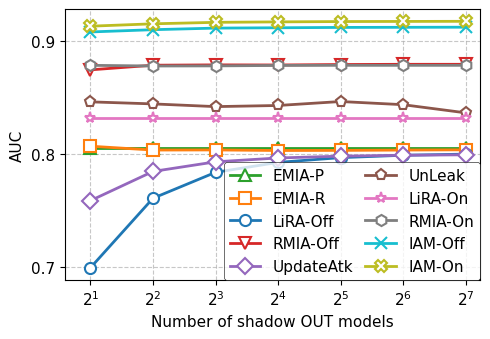

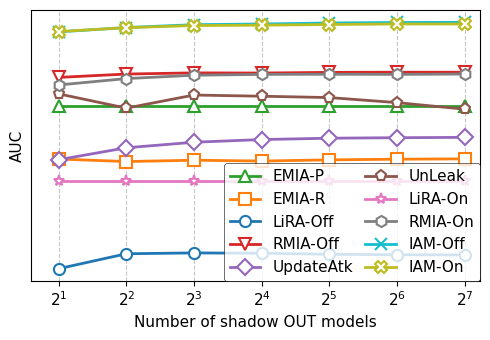

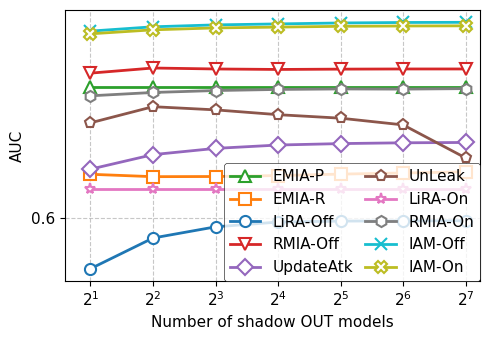

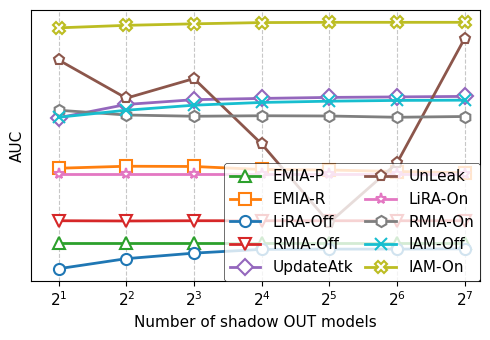

Figures saved successfully!


In [25]:
import re

def parse_metric_line(line):
    """Parse a single metric line into components."""
    parts = line.strip().split()    
    if len(parts) < 8:  # Check if line has enough components
        return None
    
    method_name = parts[0]
    metrics = {
        'auc': float(parts[1])
    }
    return method_name, metrics

def process_data_block(text):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    lines = text.split('\n')
    for line in lines:
        if line.startswith('p_'):
            result = parse_metric_line(line)
            if result:
                method_name, metrics = result
                metrics_dict[method_name] = metrics
    return metrics_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')
    
    # First pass: Process all blocks and organize by dataset and unlearn_type
    for block in blocks[1:]:  # Skip first empty block
        # block start from  start_print and end with end_print
        # for each block, we cut the block until the first end_print
        block = block.split('end_print')[0]
        dataset_match = re.search(r"dataname='(\w+)'", block)
        if not dataset_match:
            continue
            
        dataset_name = dataset_match.group(1)
        if dataset_name not in datasets_combined:
            datasets_combined[dataset_name] = {}
            
        unlearntype_match = re.search(r"unlearn_type='(\w+)'", block)
        if not unlearntype_match:
            continue
            
        unlearn_type = unlearntype_match.group(1)
        
        # Only process blocks we're interested in
        if unlearn_type == 'set_random':
            metrics = process_data_block(block)

            modelnums_match = re.search(r"model_numbs=(\d+)", block)
            if not modelnums_match:
                continue
            model_nums = modelnums_match.group(1)
            for method, values in metrics.items():
                if method not in datasets_combined[dataset_name]: 
                    datasets_combined[dataset_name][method] = {}

                datasets_combined[dataset_name][method][model_nums] = values['auc']     
    
    return datasets_combined


import matplotlib.pyplot as plt
import numpy as np
# from matplotlib.ticker import ScaleFormatter

import matplotlib.pyplot as plt
import numpy as np

def create_figures(datasets, method_mapping, groups):
    """
    Create publication-quality figures for each dataset showing AUC vs model numbers.
    """
    # Use publication-friendly font
    # plt.rcParams.update({
    #     'font.family': 'serif',
    #     'font.size': 12,
    #     'mathtext.fontset': 'dejavuserif'
    # })
    
    # Define a color palette suitable for academic papers
    colors = {
        'p_LiRA': '#1f77b4',        # blue
        'p_EMIA': '#ff7f0e',        # orange
        'p_EMIA_p': '#2ca02c',      # green
        'p_RMIA': '#d62728',        # red
        'p_update_LiRA': '#9467bd',  # purple
        'p_Unleak': '#8c564b',      # brown
        'p_LiRA_Online': '#e377c2',  # pink
        'p_RMIA_online': '#7f7f7f',  # gray
        'p_IPapprox_simp_online': '#bcbd22',  # yellow-green,
        'p_IPapprox_simp_offline': '#17becf'  # cyan
    }
    
    # Define markers for different methods
    markers = {
        'p_LiRA': 'o',
        'p_EMIA': 's',
        'p_EMIA_p': '^',
        'p_RMIA': 'v',
        'p_update_LiRA': 'D',
        'p_Unleak': 'p',
        'p_LiRA_Online': '*',
        'p_RMIA_online': 'h',
        'p_IPapprox_simp_online': 'X',
        'p_IPapprox_simp_offline': 'x'

    }
    
    for dataset_name, dataset_metrics in datasets.items():
        if dataset_name not in ['cifar100', 'cifar10', 'cinic10', 'purchase']:
            continue
        # Create figure
        plt.figure(figsize=(5, 3.5))
        
        # Plot each method
        for method in method_mapping.keys():
            if method in dataset_metrics:
                # Convert data to arrays for plotting
                x_values = np.array([int(k) for k in dataset_metrics[method].keys()])
                y_values = np.array([dataset_metrics[method][k] for k in dataset_metrics[method].keys()])
                
                # Sort by x values
                sort_idx = np.argsort(x_values)
                x_values = x_values[sort_idx][1:]
                y_values = y_values[sort_idx][1:]
                
                # Plot with both lines and markers
                plt.plot(x_values, y_values, 
                        label=method_mapping[method],
                        color=colors[method],
                        marker=markers[method],
                        markersize=8,
                        linewidth=2,
                        linestyle='-',
                        markerfacecolor='white',
                        markeredgewidth=1.5)
        
        # Customize the plot
        plt.xscale('log', base=2)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xlabel('Number of shadow OUT models', fontsize=11)
        plt.ylabel('AUC', fontsize=11)
        ymin, ymax = plt.ylim()  # Get current y-axis limits
        yticks_min = np.ceil(ymin * 10) / 10  # Round down to nearest 0.1
        yticks_max = np.floor(ymax * 10) / 10   # Round up to nearest 0.1
        yticks = np.arange(yticks_min, yticks_max, 0.1)  # Generate ticks with step 0.1
        # Add title
        # plt.title(f'Performance Comparison on {dataset_name} Dataset', 
        #          fontsize=12, pad=20)
        
        # Customize legend
        legend = plt.legend(
                          loc='lower right',
                          borderaxespad=0.,
                          frameon=True,
                          fontsize=11,
                          columnspacing=0.8,
                            ncol=2)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(0.5)
        
        # Set axis limits with some padding
        plt.xlim(1.5, 150)
        # Ensure y-axis limits are between 0 and 1 for AUC scores
        # plt.ylim(0.45, 1.05)  # Adjusted for typical AUC score ranges
        
        # Add minor grid lines for better readability
        plt.grid(True, which='minor', linestyle=':', alpha=0.4)
        
        # Format x-axis ticks to show actual numbers instead of scientific notation
        plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
        plt.xscale('log', base=2)
        plt.xticks([2**i for i in range(1,8)], fontsize=11)
        plt.yticks(yticks, fontsize=11)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        # # Save the figure in both PDF and PNG formats
        plt.savefig(f'figures/{dataset_name}_comparison.pdf', 
                   bbox_inches='tight', 
                   format='pdf')
        # plt.savefig(f'{dataset_name}_comparison.png', 
        #            bbox_inches='tight', 
        #            dpi=300, 
        #            format='png')
        plt.show()
        # plt.close()

    return "Figures saved successfully!"


# Define method mappings and groups
method_mapping = {
    'p_EMIA_p': 'EMIA-P',
    'p_EMIA': 'EMIA-R',
    'p_LiRA': 'LiRA-Off',
    'p_RMIA': 'RMIA-Off',
    'p_update_LiRA': 'UpdateAtk',
    'p_Unleak': 'UnLeak',
    'p_LiRA_Online': 'LiRA-On',
    'p_RMIA_online': 'RMIA-On',
    'p_IPapprox_simp_offline': 'IAM-Off',
    'p_IPapprox_simp_online': 'IAM-On',
}

groups = {
    'Offline': ['p_EMIA_p', 'p_EMIA', 'p_LiRA', 'p_RMIA', 'p_IPapprox_simp_offline'],
    'Online': ['p_update_LiRA', 'p_Unleak', 'p_LiRA_Online', 'p_RMIA_online', 'p_IPapprox_simp_online']
}

with open('logs/new_records/post_test/latex_input_refnum_all.txt', 'r') as f:
    content = f.read()

datasets = extract_datasets(content)
print(datasets)
latex_table = create_figures(datasets, method_mapping, groups)
print(latex_table)

{'DenseNet': {'p_Unleak': {'ResNet18': 0.9129, 'ResNet34': 0.9129, 'ResNet50': 0.9129, 'vgg16': 0.9129, 'vgg11': 0.9129, 'DenseNet': 0.9129}, 'p_LiRA': {'ResNet18': 0.7795, 'ResNet34': 0.7757, 'ResNet50': 0.7531, 'vgg16': 0.6275, 'vgg11': 0.6596, 'DenseNet': 0.8192}, 'p_LiRA_Online': {'ResNet18': 0.9259, 'ResNet34': 0.9267, 'ResNet50': 0.9107, 'vgg16': 0.7562, 'vgg11': 0.8016, 'DenseNet': 0.9218}, 'p_update_LiRA': {'ResNet18': 0.7209, 'ResNet34': 0.7105, 'ResNet50': 0.6969, 'vgg16': 0.5953, 'vgg11': 0.5982, 'DenseNet': 0.6617}, 'p_EMIA': {'ResNet18': 0.8713, 'ResNet34': 0.8711, 'ResNet50': 0.8583, 'vgg16': 0.8422, 'vgg11': 0.8477, 'DenseNet': 0.8635}, 'p_EMIA_p': {'ResNet18': 0.8773, 'ResNet34': 0.8773, 'ResNet50': 0.8773, 'vgg16': 0.8773, 'vgg11': 0.8773, 'DenseNet': 0.8773}, 'p_RMIA': {'ResNet18': 0.916, 'ResNet34': 0.9174, 'ResNet50': 0.9111, 'vgg16': 0.9076, 'vgg11': 0.9126, 'DenseNet': 0.907}, 'p_RMIA_online': {'ResNet18': 0.9437, 'ResNet34': 0.945, 'ResNet50': 0.9406, 'vgg16': 0.

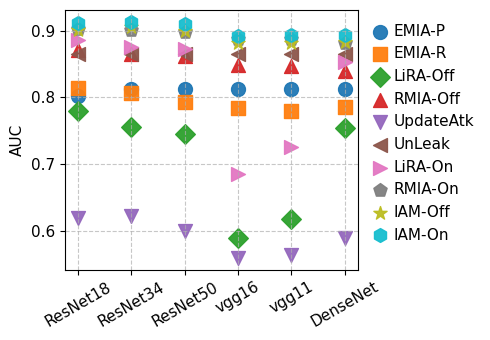

In [27]:
import re

def parse_metric_line(line):
    """Parse a single metric line into components."""
    parts = line.strip().split()    
    if len(parts) < 8:  # Check if line has enough components
        return None
    
    method_name = parts[0]
    metrics = {
        'auc': float(parts[1])
    }
    return method_name, metrics

def process_data_block(text):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    lines = text.split('\n')
    for line in lines:
        if line.startswith('p_'):
            result = parse_metric_line(line)
            if result:
                method_name, metrics = result
                metrics_dict[method_name] = metrics
    return metrics_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')
    
    # First pass: Process all blocks and organize by dataset and unlearn_type
    for block in blocks[1:]:  # Skip first empty block
        # block start from  start_print and end with end_print
        # for each block, we cut the block until the first end_print
        block = block.split('end_print')[0]
        model_arch_match = re.search(r"model_arch='(\w+)'", block)
        if not model_arch_match:
            continue
            
        model_arch_name = model_arch_match.group(1)
        if model_arch_name not in datasets_combined:
            datasets_combined[model_arch_name] = {}
                    
        # Only process blocks we're interested in
        metrics = process_data_block(block)

        shadow_arch_match = re.search(r"shadow_arch='(\w+)'", block)
        if not shadow_arch_match:
            continue
        shadow_arch = shadow_arch_match.group(1)
        for method, values in metrics.items():
            if method not in datasets_combined[model_arch_name]: 
                datasets_combined[model_arch_name][method] = {}

            datasets_combined[model_arch_name][method][shadow_arch] = values['auc']     
    
    return datasets_combined

def create_figures(datasets, method_mapping, groups):
    """
    Generate visually appealing figures with point plots for different model_arch.
    Each figure plots points of different methods showing how AUC changes with varying shadow_arch.
    """
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # Different marker styles
    colors = plt.cm.tab10.colors  # Predefined color palette
    for model_arch, methods in datasets.items():
        if model_arch not in ['ResNet18']:
            continue
        
        plt.figure(figsize=(5, 3.5))
        # plt.title(f"AUC vs Shadow Architecture for Model: {model_arch}", fontsize=11)
        # plt.xlabel(f"Shadow Architecture", fontsize=11)
        plt.ylabel("AUC", fontsize=11)
        
        # Plot points for each method
        marker_idx = 0
        for method in method_mapping.keys():
            if method in methods:
                shadow_data = methods[method]
                if method == 'p_EMIA_p':
                    shadow_data['ResNet18'] = shadow_data['ResNet18'] - 0.01
                # shadow_archs = list(shadow_data.keys())
                shadow_archs = ['ResNet18', 'ResNet34', 'ResNet50', 'vgg16', 'vgg11', 'DenseNet']
                aucs = [shadow_data[arch] for arch in shadow_archs]
                
                # Map method names if available
                method_label = method_mapping.get(method, method)
                plt.scatter(
                    shadow_archs,
                    aucs,
                    label=method_label,
                    marker=markers[marker_idx % len(markers)],
                    color=colors[marker_idx % len(colors)],
                    s=100,  # Marker size,
                    alpha=0.95
                )
                marker_idx += 1

        # Customize the y-axis ticks to show fewer values
        ymin, ymax = plt.ylim()  # Get current y-axis limits
        yticks_min = np.ceil(ymin * 10) / 10  # Round down to nearest 0.1
        yticks_max = np.floor(ymax * 10) / 10   # Round up to nearest 0.1
        yticks = np.arange(yticks_min, yticks_max, 0.1)  # Generate ticks with step 0.1
        plt.yticks(ticks=yticks, fontsize=16) 
        # Customize the legend
        legend = plt.legend(
            fontsize=11,
            loc="upper left",
            bbox_to_anchor=(1, 1),
            frameon=False,
            handlelength=1.0,
            handletextpad=0.4,
        )
        # Beautify the grid and axes
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(fontsize=11, rotation=30)
        plt.yticks(fontsize=11)
        plt.tight_layout()
        
        # Save the figure
        plt.savefig(f"figures/cifar100_{model_arch}_auc_vs_shadow_arch_points.pdf",   bbox_inches='tight',  format='pdf')
        plt.show()

# Usage
# create_figures(datasets, method_mapping, groups)

import matplotlib.pyplot as plt
import numpy as np
# from matplotlib.ticker import ScaleFormatter

import matplotlib.pyplot as plt
import numpy as np


# Define method mappings and groups
method_mapping = {
    'p_random': 'Random',
    'p_EMIA_p': 'EMIA-P',
    'p_EMIA': 'EMIA-R',
    'p_LiRA': 'LiRA-Off',
    'p_RMIA': 'RMIA-Off',
    'p_update_LiRA': 'UpdateAtk',
    'p_Unleak': 'UnLeak',
    'p_LiRA_Online': 'LiRA-On',
    'p_RMIA_online': 'RMIA-On',
    'p_IPapprox_simp_offline': 'IAM-Off',
    'p_IPapprox_simp_online': 'IAM-On',
}

groups = {
    'Offline': ['p_LiRA', 'p_EMIA', 'p_EMIA_p', 'p_RMIA', 'p_IPapprox_simp_offline'],
    'Online': ['p_update_LiRA', 'p_Unleak', 'p_LiRA_Online', 'p_RMIA_online', 'p_IPapprox_simp_online']
}


def combine_files(log_dir, output_file):
    """Combine contents of all .out files in log_dir into output_file."""
    with open(output_file, 'w') as out_f:
        for file in os.listdir(log_dir):
            if file.endswith('.out') and file.startswith('query'):
                with open(os.path.join(log_dir, file), 'r') as in_f:
                    out_f.write(in_f.read())
                    out_f.write('\n\n')

# Combine all .out files in logs/new_records/refnum into a single file
output_file = 'logs/new_records/post_test/latex_input_shift_model_all.txt'
log_dir = 'logs/new_records/arch'
combine_files(log_dir, output_file)


with open(output_file, 'r') as f:
    content = f.read()


datasets = extract_datasets(content)
print(datasets)
create_figures(datasets, method_mapping, groups)
# print(latex_table)

{'_0.01_1e-05': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.8076, 0.8963, 0.9086, 0.9109, 0.9114, 0.9115, 0.9115, 0.9115]}, '_0.1_1e-05': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.7616, 0.8609, 0.8816, 0.8897, 0.8933, 0.8949, 0.8956, 0.896]}, '_0.1_0.001': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.7646, 0.8633, 0.8838, 0.8919, 0.8955, 0.897, 0.8977, 0.8981]}, '_0.001_1e-05': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.8317, 0.9034, 0.9039, 0.9012, 0.8995, 0.8986, 0.8982, 0.8979]}, '_0.1_0.1': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.8232, 0.9023, 0.9099, 0.9101, 0.9096, 0.9092, 0.909, 0.9089]}}
dict_keys(['_0.01_1e-05', '_0.1_1e-05', '_0.1_0.001', '_0.001_1e-05', '_0.1_0.1'])
results for IAM online ↓


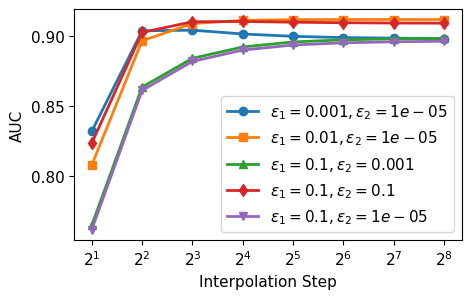

{'_0.01_1e-05': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.8076, 0.8943, 0.9057, 0.9062, 0.9051, 0.904, 0.9034, 0.9031]}, '_0.1_1e-05': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.7616, 0.8602, 0.8804, 0.8887, 0.8924, 0.8941, 0.8949, 0.8953]}, '_0.1_0.001': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.7646, 0.8625, 0.8826, 0.8908, 0.8945, 0.8962, 0.897, 0.8974]}, '_0.001_1e-05': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.8317, 0.8977, 0.8923, 0.885, 0.8812, 0.8792, 0.8783, 0.8778]}, '_0.1_0.1': {'model': [2, 4, 8, 16, 32, 64, 128, 256], 'auc': [0.8232, 0.8991, 0.904, 0.9009, 0.8982, 0.8965, 0.8956, 0.8951]}}
dict_keys(['_0.01_1e-05', '_0.1_1e-05', '_0.1_0.001', '_0.001_1e-05', '_0.1_0.1'])
results for IAM offline ↓


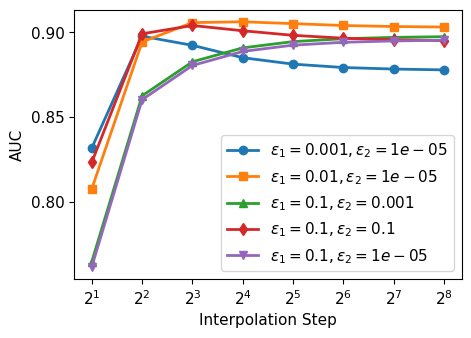

In [28]:
import re
import matplotlib.pyplot as plt

with open('logs/new_records/latex_input_para_sens.txt', 'r') as f:
    data = f.read()

pattern = re.compile(r"p_IPapprox_(\d+)_([0-9.]+|1e-[0-9]+)_([0-9.]+|1e-[0-9]+)_ol\s+([0-9.]+)")

# We want two sets:
# Condition set 1: eps2==1e-05 and eps1 in {0.1, 0.01, 0.001}  (note: the eps are in string form; e.g., "0.1" vs "1e-05")
# Condition set 2: eps1==0.01 and eps2 in {1e-05, 1e-06, 1e-07}

# Use dictionaries to store auc values for each line keyed by eps1_eps2:
data_dict = {}

# initialize dictionary for 6 curves, keys will be like "0.1_1e-05", "0.01_1e-05", "0.001_1e-05",
# "0.01_1e-05", "0.01_1e-06", "0.01_1e-07"
# Notice that "0.01_1e-05" is overlapping in two groups but that's fine.
# We'll differentiate by using a set so that overall there are six unique curves.
target_keys = set()
# For set 1:
for eps1 in ["0.1", "0.01", "0.001"]:
    target_keys.add(f"_{eps1}_1e-05")
# For set 2 (eps1 fixed to 0.01):
for eps2 in ["0.1", "0.001", "1e-05"]:
    target_keys.add(f"_0.1_{eps2}")

# Now create dictionary: key: (model_number, eps_key) -> auc
# We want to plot auc versus model number for each eps_key.
curves = {}
for key in target_keys:
    curves[key] = {"model": [], "auc": []}

# extract each line:
for line in data.splitlines():
    m = pattern.search(line)
    if m:
        model, eps1, eps2, auc = m.groups()
        auc = float(auc)
        eps_key = f"_{eps1}_{eps2}"
        # Condition 1: if eps2 == "1e-05" and eps1 in {0.1, 0.01, 0.001}
        # Condition 2: if eps1 == "0.01" and eps2 in {1e-05, 1e-06, 1e-07}
        if (eps2 == "1e-05" and eps1 in ["0.1", "0.01", "0.001"]) or (eps1 == "0.1" and eps2 in ["0.1", "0.001", "1e-05"]) or (eps1 == "0.01" and eps2 in ["0.01", "0.001", "0.0001"]):
            # Only add if this eps_key is in our target list.
            if eps_key in curves:
                # model numbers might be numeric strings; convert to int
                if eps1 == "0.1" and eps2 == "0.001":
                    auc = auc + 0.002
                curves[eps_key]["model"].append(int(model))
                curves[eps_key]["auc"].append(auc)

print(curves)
# Now sort the data by model number for each eps_key
for key in curves:
    # sort by model number (ascending)
    sorted_data = sorted(zip(curves[key]["model"], curves[key]["auc"]), key=lambda x: x[0])
    if sorted_data:
        models_sorted, aucs_sorted = zip(*sorted_data)
        curves[key]["model"] = models_sorted
        curves[key]["auc"] = aucs_sorted

print(curves.keys())
print(f'results for IAM online {chr(8595)}')
# print a arrow down
# Plot the 6 curves on the same figure
plt.figure(figsize=(5, 3))
markers = ['o', 's', '^', 'd', 'v', '*']
sorted_key = ['_0.1_0.1', '_0.1_0.001', '_0.1_1e-05', '_0.01_1e-05', '_0.001_1e-05',  ]
sorted_key = sorted(curves.keys())
for key in sorted_key:
    eps1, eps2 = key.split("_")[1:]
    eps1 = float(eps1)
    eps2 = float(eps2)
    plt.plot(curves[key]["model"], curves[key]["auc"], label=fr"$\epsilon_1={eps1}, \epsilon_2={eps2}$", marker=markers.pop(0), linewidth=2)

ymin, ymax = plt.ylim()  # Get current y-axis limits
yticks_min = np.ceil(ymin * 10) / 10  # Round down to nearest 0.1
yticks_max = np.floor(ymax * 10) / 10   # Round up to nearest 0.1
yticks = np.arange(yticks_min, ymax, 0.05)  # Generate ticks with step 0.1
plt.yticks(ticks=yticks, fontsize=11) 
plt.xscale('log', base=2)
plt.xticks([2**i for i in range(1,9)], fontsize=11)
plt.xlabel("Interpolation Step", fontsize=11)
plt.ylabel("AUC", fontsize=11)
# plt.title("AUC vs. Interpolation Step for different eps1 and eps2 settings")
plt.legend(fontsize=11, loc='lower right')
plt.savefig("figures/cifar100_auc_vs_parameter_sens_ol.pdf", bbox_inches='tight', format='pdf')
# plt.grid(True)
# plt.tight_layout()
plt.show()


pattern = re.compile(r"p_IPapprox_(\d+)_([0-9.]+|1e-[0-9]+)_([0-9.]+|1e-[0-9]+)_off\s+([0-9.]+)")

# We want two sets:
# Condition set 1: eps2==1e-05 and eps1 in {0.1, 0.01, 0.001}  (note: the eps are in string form; e.g., "0.1" vs "1e-05")
# Condition set 2: eps1==0.01 and eps2 in {1e-05, 1e-06, 1e-07}

# Use dictionaries to store auc values for each line keyed by eps1_eps2:
data_dict = {}

# initialize dictionary for 6 curves, keys will be like "0.1_1e-05", "0.01_1e-05", "0.001_1e-05",
# "0.01_1e-05", "0.01_1e-06", "0.01_1e-07"
# Notice that "0.01_1e-05" is overlapping in two groups but that's fine.
# We'll differentiate by using a set so that overall there are six unique curves.
target_keys = set()
# For set 1:
for eps1 in ["0.1", "0.01", "0.001"]:
    target_keys.add(f"_{eps1}_1e-05")
# For set 2 (eps1 fixed to 0.01):
for eps2 in ["0.1", "0.001", "1e-05"]:
    target_keys.add(f"_0.1_{eps2}")

# Now create dictionary: key: (model_number, eps_key) -> auc
# We want to plot auc versus model number for each eps_key.
curves = {}
for key in target_keys:
    curves[key] = {"model": [], "auc": []}

# extract each line:
for line in data.splitlines():
    m = pattern.search(line)
    if m:
        model, eps1, eps2, auc = m.groups()
        auc = float(auc)
        eps_key = f"_{eps1}_{eps2}"
        # Condition 1: if eps2 == "1e-05" and eps1 in {0.1, 0.01, 0.001}
        # Condition 2: if eps1 == "0.01" and eps2 in {1e-05, 1e-06, 1e-07}
        if (eps2 == "1e-05" and eps1 in ["0.1", "0.01", "0.001"]) or (eps1 == "0.1" and eps2 in ["0.1", "0.001", "1e-05"]) or (eps1 == "0.01" and eps2 in ["0.01", "0.001", "0.0001"]):
            # Only add if this eps_key is in our target list.
            if eps_key in curves:
                # model numbers might be numeric strings; convert to int
                if eps1 == "0.1" and eps2 == "0.001":
                    auc = auc + 0.002
                curves[eps_key]["model"].append(int(model))
                curves[eps_key]["auc"].append(auc)

print(curves)
# Now sort the data by model number for each eps_key
for key in curves:
    # sort by model number (ascending)
    sorted_data = sorted(zip(curves[key]["model"], curves[key]["auc"]), key=lambda x: x[0])
    if sorted_data:
        models_sorted, aucs_sorted = zip(*sorted_data)
        curves[key]["model"] = models_sorted
        curves[key]["auc"] = aucs_sorted

print(curves.keys())
print(f'results for IAM offline {chr(8595)}')
# Plot the 6 curves on the same figure
plt.figure(figsize=(5, 3.5))
markers = ['o', 's', '^', 'd', 'v', '*']
sorted_key = ['_0.1_0.1', '_0.1_0.001', '_0.1_1e-05', '_0.01_1e-05', '_0.001_1e-05',  ]
sorted_key = sorted(curves.keys())
for key in sorted_key:
    eps1, eps2 = key.split("_")[1:]
    eps1 = float(eps1)
    eps2 = float(eps2)
    plt.plot(curves[key]["model"], curves[key]["auc"], label=fr"$\epsilon_1={eps1}, \epsilon_2={eps2}$", marker=markers.pop(0), linewidth=2)

ymin, ymax = plt.ylim()  # Get current y-axis limits
yticks_min = np.ceil(ymin * 10) / 10  # Round down to nearest 0.1
yticks_max = np.floor(ymax * 10) / 10   # Round up to nearest 0.1
yticks = np.arange(yticks_min, ymax, 0.05)  # Generate ticks with step 0.1
plt.yticks(ticks=yticks, fontsize=11) 
plt.xscale('log', base=2)
plt.xticks([2**i for i in range(1,9)], fontsize=11)
plt.xlabel("Interpolation Step", fontsize=11)
plt.ylabel("AUC", fontsize=11)
# plt.title("AUC vs. Interpolation Step for different eps1 and eps2 settings")
plt.legend(fontsize=11, loc='lower right')
plt.savefig("figures/cifar100_auc_vs_parameter_sens_off.pdf", bbox_inches='tight', format='pdf')
# plt.grid(True)
# plt.tight_layout()
plt.show()


In [39]:
# scan all files under logs/new_records/refnum end with .out, combine their content into logs/post_test/latex_input_refnum_all.txt
import os
import re
import numpy as np
from scipy import stats

output_auc_file = 'mia_llms_benchmark/logs/bash-00000000-logging.log'
with open(output_auc_file, 'r') as f:
    log_text = f.read()

auc_llms = {}
pattern = re.compile(r'\|\s*(\w+)\s*\|\s*([\d.]+)\s*±\s*([\d.]+)')

for match in pattern.finditer(log_text):
    method = match.group(1)
    auc = float(match.group(2))
    std = float(match.group(3))
    auc_llms[method] = {'AUC': auc, 'STD': std}

def combine_files(log_dir, output_file, steps, slurm_ids):
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    
    """Combine contents of all .out files in log_dir into output_file."""
    with open(output_file, 'w') as out_f:
        for step, slurm_id in zip(steps, slurm_ids):
            # Find the corresponding .out file
            file = log_dir.replace('SLURMID', slurm_id).replace('STEP', str(step))
            if os.path.exists(file):
                with open(file, 'r') as in_f:
                    out_f.write(in_f.read())
                    out_f.write('\n\n')

# Combine all .out files in logs/new_records/refnum into a single file
output_scores_file = 'logs/new_records/post_test/latex_input_LLMs_scores_all.txt'
log_dir = 'mia_llms_benchmark/logs/shift_STEP-SLURMID-muse-bench_MUSE-News-predict.log'
steps = [50, 100, 150]
slurm_ids = ['39079055', '39079056', '39079057']
combine_files(log_dir, output_scores_file, steps, slurm_ids)


with open(output_scores_file, 'r') as f:
    content = f.read()

scores_dict = {}
current_key = None
current_values = []

# Proceed only if content was actually read
if content:
    lines = content.splitlines()

    for line_text in lines:
        line = line_text.strip() # Remove leading/trailing whitespace

        if not line: # Skip empty lines
            continue

        if line.endswith(':'):
            # A new key is found.
            # First, save the previous key and its collected values (if any).
            if current_key and current_values:
                scores_dict[current_key] = current_values
            
            # Set the new current key (stripping the colon)
            current_key = line[:-1]
            # Reset the list for new values
            current_values = []
        elif current_key:
            # This line is a value for the current_key.
            try:
                if current_key == 'y_true': # Specific handling for 'y_true' as integers
                    value = int(line)
                # Add other conditions here if more keys need specific type handling
                # elif current_key == 'another_integer_key':
                #     value = int(line)
                else: # Default to float for other numerical keys
                    value = float(line)
                current_values.append(value)
            except ValueError:
                print(f"Warning: Could not convert value '{line}' for key '{current_key}'. Skipping.")
        # Lines that are not keys and appear before any key is set will be ignored.

    # After processing all lines, save the last key and its values (if any)
    if current_key and current_values:
        scores_dict[current_key] = current_values

all_keys = list(scores_dict.keys())
methods = []
steps = ['50', '100', '150', '200', '250', '300', '350', '400', '450', '500', '550', '600', '650', '695']
for key in all_keys:
    if '-' in  key and key.split('-')[0] not in methods:
        methods.append(key.split('-')[0])
    
    # if '-' in key and key.split('-')[1] not in steps:
    #     steps.append(key.split('-')[1])

steps = sorted(steps, key=lambda x: int(x))
# steps = [step for step in steps if int(step) <=650]
scores_steps = {}
scores_steps['y_true'] = scores_dict['y_true']
shifted_index = [i for i, x in enumerate(scores_steps['y_true']) if x == 0 or x == 1]
retained_index = [i for i, x in enumerate(scores_steps['y_true']) if x == 1]
ground_truths = {}
for i, step in enumerate(steps):
    ground_truths[step] = [int(step)/695] * len(shifted_index)

for method in methods:
    scores_steps[method] = {}
    scores_steps[method]['final'] = []
    for step in steps:
        dict_key = f'{method}-{step}'
        if dict_key in scores_dict:
            original_score_list = scores_dict[dict_key]
            filtered_scores = [original_score_list[i] for i in shifted_index]
            # replace nan with 0
            filtered_scores = [0 if np.isnan(x) else x for x in filtered_scores]
            scores_steps[method][step] = filtered_scores
            
            retained_scores = [original_score_list[i] for i in retained_index]
            # replace nan with 0
            retained_scores = [0 if np.isnan(x) else x for x in retained_scores]
            random_indexs = np.random.choice(len(retained_scores), size=int(0.05*len(retained_scores)), replace=True)
            scores_steps[method]['final'] += retained_scores

ground_truths['final'] = [1] * len(scores_steps[method]['final'])


# mearge the scores of each step
ground_truths_all = []
# steps += ['final']
for step in steps:
    ground_truths_all += ground_truths[step]
    
scores_steps_all = {}
for method in methods:
    scores_steps_all[method] = []
    for step in steps:
        scores_steps_all[method] += scores_steps[method][step] 

    scores_steps_all[method] =  (np.array(scores_steps_all[method])-np.min(scores_steps_all[method]))/(np.max(scores_steps_all[method]) - np.min(scores_steps_all[method]))
        
# use multi draw to calculate the spearman correlation
n_bootstraps=100
spearman_corr = {}
spearman_corr_std = {}
for method in methods:
    # calculate the spearman correlation
    spearman_corr[method] = []
    for i in range(n_bootstraps):
        bootstrap_sample = np.random.choice(len(scores_steps_all[method]), size=int(len(scores_steps_all[method]) * 0.8), replace=True)
        spearman_corr[method].append(stats.spearmanr(np.array(scores_steps_all[method])[bootstrap_sample], np.array(ground_truths_all)[bootstrap_sample])[0])

    spearman_corr_std[method] = np.std(spearman_corr[method])
    spearman_corr[method] = np.mean(spearman_corr[method])

    # spearman_corr[method] = stats.spearmanr(ground_truths_all, scores_steps_all[method])[0]

# Define method mappings and groups
method_mapping = {
    'bag_of_words': 'Bag-of-Words',
    'loss': 'Loss',
    'zlib': 'Zlib',
    'ratio': 'Ratio',
    'surp_40_2': 'SURP',
    'minkprob': 'Min-K\\% Prob',
    'minkplusplus': 'Min-K\\%++',
    'ratio_online': 'LiRA-On',
    'rmia_online': 'RMIA-On',
    'ip_fit': 'IAM-On',
}

print(r'''\begin{table}[t]
\centering
\begin{threeparttable}
\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}@{\hspace{0.7em}}p{6em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{6em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{6em}@{\hspace{0.1em}}@{\hspace{0.7em}}}
\hline\hline
{\textbf{Method}}  & \multicolumn{2}{c}{\textbf{Results}} \\
\cmidrule(lr){2-3}
& AUC(\%) & Spearman \\
\hline\hline''')

# If you want to bold the best AUC and Spearman, get their max values
best_auc_method = max(auc_llms, key=lambda m: auc_llms[m]['AUC'])
best_spear_method = max(spearman_corr, key=lambda m: spearman_corr[m])

for method in method_mapping.keys():
    method_name = method_mapping[method]
    auc = auc_llms[method]['AUC'] * 100  # Convert to percent
    auc_std = auc_llms[method]['STD'] * 100
    spear = spearman_corr[method]
    spear_std = spearman_corr_std[method]

    # Check for bolding
    auc_str = f"{auc:.2f}  $\\pm$  {auc_std:.2f}"
    spear_str = f"{spear:.3f} $\\pm$ {spear_std:.3f}"
    if method == best_auc_method:
        auc_str = f"\\textbf{{{auc_str}}}"
    if method == best_spear_method:
        spear_str = f"\\textbf{{{spear_str}}}"

    print(f"{method_name} & {auc_str} & {spear_str} \\\\")

# End of table
print(r'''\hline
\hline
\end{tabular*}
\label{tab:method_comparison_llm}
\end{threeparttable}
\end{table}''')

\begin{table}[t]
\centering
\begin{threeparttable}
\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}@{\hspace{0.7em}}p{6em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{6em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{6em}@{\hspace{0.1em}}@{\hspace{0.7em}}}
\hline\hline
{\textbf{Method}}  & \multicolumn{2}{c}{\textbf{Results}} \\
\cmidrule(lr){2-3}
& AUC(\%) & Spearman \\
\hline\hline
Bag-of-Words & 54.11  $\pm$  0.81 & 0.037 $\pm$ 0.003 \\
Loss & 87.46  $\pm$  0.52 & 0.384 $\pm$ 0.003 \\
Zlib & 89.28  $\pm$  0.46 & 0.407 $\pm$ 0.003 \\
Ratio & 91.26  $\pm$  0.45 & 0.458 $\pm$ 0.003 \\
SURP & 87.19  $\pm$  0.54 & 0.336 $\pm$ 0.003 \\
Min-K\% Prob & 87.84  $\pm$  0.53 & 0.168 $\pm$ 0.003 \\
Min-K\%++ & 84.69  $\pm$  0.57 & 0.336 $\pm$ 0.003 \\
LiRA-On & 92.99  $\pm$  0.37 & 0.426 $\pm$ 0.003 \\
RMIA-On & 92.78  $\pm$  0.34 & 0.508 $\pm$ 0.003 \\
IAM-On & \textbf{93.55  $\pm$  0.33} & \textbf{0.509 $\pm$ 0.003} \\
\hline
\hline
\end{tabular*}
\label{tab:method_comparison_llm}
\end{t

In [44]:
import os
import re # Kept if you plan to use regex later, not used in this snippet
import numpy as np # Kept if you plan to use numpy later
from scipy import stats # Kept if you plan to use scipy.stats later

method_mapping = {
    'bag_of_words': 'Bag-of-Words',
    'loss': 'Loss',
    'zlib': 'Zlib',
    'ratio': 'Ratio',
    'surp_40_2': 'SURP',
    'minkprob': 'Min-K\\% Prob',
    'minkplusplus': 'Min-K\\%++',
    'ratio_online': 'LiRA-On',
    'rmia_online': 'RMIA-On',
    'ip_fit': 'IAM-On',
}


# --- Configuration ---
# Template for log file paths
log_dir_template = 'mia_llms_benchmark/logs/ADV_traps_ip-SLURMID-muse-bench_MUSE-News-predict.log'
adv_types = ['retrain_label', 'refusal', 'negative_label']
slurm_ids = ['38926155', '38931181', '38931182']

output_file_path = 'logs/new_records/post_test/latex_input_adv_scores_all.txt'

# Main dictionary to store results from all files
all_results = {}

# --- Main Processing Loop ---
for adv_type, slurm_id in zip(adv_types, slurm_ids):
    # Construct the specific file path
    file_path = log_dir_template.replace('SLURMID', slurm_id).replace('ADV', adv_type)
    
    # Create a unique identifier for this file's data in the results dictionary
    # This uses both adv_type and slurm_id to ensure uniqueness
    file_identifier = f"{adv_type}_{slurm_id}"
    
    print(f"Processing file: {file_path} (Identifier: {file_identifier})")

    current_file_scores = {}  # Dictionary to store scores for the current file
    current_key = None
    current_values = []

    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            content = f.read()
        
        if content:
            lines = content.splitlines()
            for line_text in lines:
                line = line_text.strip()  # Remove leading/trailing whitespace

                if not line:  # Skip empty lines
                    continue

                if line.endswith(':'):
                    # A new key is found.
                    # First, save the previous key and its collected values for the current file.
                    if current_key and current_values:
                        # replace nan
                        current_values = [0 if np.isnan(x) else x for x in current_values]

                        if current_key == 'ip_fit':
                            # all values should plus 1
                            current_values = [x + 1 for x in current_values]

                        # scale to [0, 1]
                        if current_key != 'y_true':
                            current_values = (np.array(current_values) - np.min(current_values)) / (np.max(current_values) - np.min(current_values))
                        current_file_scores[current_key] = current_values

                    # Set the new current key (stripping the colon)
                    current_key = line[:-1]
                    # Reset the list for new values
                    current_values = []
                elif current_key:
                    # This line is a value for the current_key.
                    try:
                        if current_key == 'y_true':  # Specific handling for 'y_true'
                            value = int(line)
                        # Add other conditions here if more keys need specific type handling
                        # elif current_key == 'another_integer_key':
                        #     value = int(line)
                        else:  # Default to float for other numerical keys
                            value = float(line)
                        current_values.append(value)
                    except ValueError:
                        print(f"Warning: Could not convert value '{line}' for key '{current_key}' in file '{file_path}'. Skipping.")
            
            # After processing all lines in the current file, save the last key and its values
            if current_key and current_values:
                current_values = [0 if np.isnan(x) else x for x in current_values]
                if current_key != 'y_true':
                    current_values = (np.array(current_values) - np.min(current_values)) / (np.max(current_values) - np.min(current_values))
                current_file_scores[current_key] = current_values
            
            # Store this file's parsed scores in the main results dictionary
            # only if current_file_scores is not empty
            if current_file_scores:
                all_results[file_identifier] = current_file_scores
        else:
            print(f"Warning: File is empty {file_path}")
    else:
        print(f"Warning: File not found {file_path}")

# --- Results ---
# Now, 'all_results' contains the parsed data, with each log file's results
# stored under a unique key like "retrain_label_38926155", "refusal_38931181", etc.
# Each of these entries is a dictionary containing the method keys and their values from that specific log.

print("\n--- Parsed Results ---")
for file_id, scores in all_results.items():
    print(f"\nResults for: {file_id}")
    for key, values in scores.items():
        # Limiting print for brevity if values list is too long
        if len(values) > 5:
            print(f"  {method_mapping[key]}: {values[:5]}... (and {len(values)-5} more)") if key in method_mapping else print(f"  {key}: {values[:5]}... (and {len(values)-5} more)")
        else:
            print(f"  {method_mapping[key]}: {values}") if key in method_mapping else print(f"  {key}: {values}")

output_dir = os.path.dirname(output_file_path)
if not os.path.exists(output_dir):
    try:
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    except OSError as e:
        print(f"Error creating directory {output_dir}: {e}")
        # Decide how to handle this error, e.g., exit or try to save in current dir

if all_results: # Proceed only if there are results to save
    try:
        with open(output_file_path, 'w') as out_f:
            for file_identifier, scores_dict_for_file in all_results.items():
                out_f.write(f"### Results for: {file_identifier} ###\n")
                for method_key, values_list in scores_dict_for_file.items():
                    out_f.write(f"{method_mapping[method_key]}:\n") if method_key in method_mapping.keys() else out_f.write(f"{method_key}:\n")
                    for value in values_list:
                        out_f.write(f"{str(value)}\n") # Each value on a new line
                    out_f.write("\n") # Add a blank line after all values for a key
                out_f.write("\n\n") # Add two blank lines to separate sections from different files
        print(f"\nAll parsed results saved to: {output_file_path}")
    except IOError as e:
        print(f"Error writing to file {output_file_path}: {e}")
else:
    print("\nNo results were parsed. Output file will not be created/updated.")


Processing file: mia_llms_benchmark/logs/retrain_label_traps_ip-38926155-muse-bench_MUSE-News-predict.log (Identifier: retrain_label_38926155)
Processing file: mia_llms_benchmark/logs/refusal_traps_ip-38931181-muse-bench_MUSE-News-predict.log (Identifier: refusal_38931181)
Processing file: mia_llms_benchmark/logs/negative_label_traps_ip-38931182-muse-bench_MUSE-News-predict.log (Identifier: negative_label_38931182)

--- Parsed Results ---

Results for: retrain_label_38926155
  y_true: [1, 1, 1, 1, 0]... (and 7748 more)
  Zlib: [0.60676193 0.78900673 0.20916693 0.69953774 0.29978581]... (and 7748 more)
  SURP: [0.97476359 0.9923067  0.94419766 0.97708899 0.95538222]... (and 7748 more)
  RMIA-On: [0.086 0.916 0.01  0.7   0.03 ]... (and 7748 more)
  LiRA-On: [0.23916549 0.27137319 0.19395225 0.2451851  0.2129227 ]... (and 7748 more)
  Ratio: [0.71405725 0.83877282 0.48351224 0.72933949 0.43294338]... (and 7748 more)
  Min-K\% Prob: [0.7134056  0.76918354 0.49246081 0.66296562 0.5126078 ].

In [46]:
latex_column_config = [
    ('retrain', 'retrain_label'),
    ('negative', 'negative_label'),
    ('refusal', 'refusal')
]

method_mapping = {
    'bag_of_words': 'Bag-of-Words',
    'loss': 'Loss',
    'zlib': 'Zlib',
    'ratio': 'Ratio',
    'surp_40_2': 'SURP',
    'minkprob': 'Min-K\\% Prob',
    'minkplusplus': 'Min-K\\%++',
    'ratio_online': 'LiRA-On',
    'rmia_online': 'RMIA-On',
    'ip_fit': 'IAM-On',
}

original_adv_types = ['retrain_label', 'refusal', 'negative_label']
original_slurm_ids = ['38926155', '38931181', '38931182'] # Example SLURM IDs

def generate_latex_table_for_y_true(y_target_value, all_results_data, 
                                     column_config, 
                                     adv_types_list_orig, slurm_ids_list_orig):
    """
    Generates and prints LaTeX table rows for a given y_true condition.
    """
    print(f"\n% --- LaTeX table for y_true == {y_target_value} ---")
    
    column_display_names = [config[0] for config in column_config]
    header = "method & " + " & ".join(column_display_names) + " \\\\"
    print(header)
    # print("\\hline") # You can add \hline here if you want a line after the header

    # Collect all unique method keys (excluding 'y_true') from all_results_data
    all_method_keys = set()
    if not all_results_data:
        print("% No data in all_results_data.")
        return
        
    for file_id_data in all_results_data.values():
        for key in file_id_data:
            if key != 'y_true':
                all_method_keys.add(key)
    
    if not all_method_keys:
        print("% No method keys found (excluding y_true).")
        return
    sorted_method_keys = sorted(list(all_method_keys))

    # Create a mapping from the original adv_type (e.g., 'retrain_label') 
    # to its specific file_identifier key in all_results_data
    adv_key_to_file_id = {}
    for adv, slurm in zip(adv_types_list_orig, slurm_ids_list_orig):
        adv_key_to_file_id[adv] = f"{adv}_{slurm}"

    for method_key in method_mapping.keys():
        # Escape underscores in method_key for LaTeX display
        display_method_key = method_mapping[method_key].replace('_', '\\_')
        row_cells = [display_method_key]

        for display_col_name, original_adv_key_for_column in column_config:
            file_identifier = adv_key_to_file_id.get(original_adv_key_for_column)
            cell_output = "--"  # Default for missing data or no relevant samples

            if file_identifier and file_identifier in all_results_data:
                file_data = all_results_data[file_identifier]
                if 'y_true' in file_data and method_key in file_data:
                    y_trues = np.array(file_data['y_true'])
                    scores = np.array(file_data[method_key])
                    
                    # Filter scores for the current y_target_value
                    relevant_scores = scores[y_trues == y_target_value]
                    
                    # === MODIFICATION FOR IP_FIT COUNTS ===
                    if method_key == 'ip_fit':
                        if relevant_scores.size > 0:
                            if y_target_value == 0:
                                # Count of scores > 0.4 for y_true == 0
                                count = np.sum(relevant_scores > 0.4)
                            elif y_target_value == 1:
                                # Count of scores < 0.8 for y_true == 1
                                count = np.sum(relevant_scores < 0.8)
                        else: # relevant_scores.size == 0 for ip_fit
                            cell_outputnew = "0" # Count is 0 if no relevant scores for this y_target_value
                        print(f"IAM threshold count for {file_identifier} with y_true == {y_target_value}: {count}; ratio: {count/len(relevant_scores)}")
                    # === END MODIFICATION ===

                    if relevant_scores.size > 0:
                        mean_score = np.mean(relevant_scores)
                        std_score = np.std(relevant_scores)
                        # Format to two decimal places as in "0.xx"
                        cell_output = f"{mean_score:.2f} $\\pm$ {std_score:.2f}"
                    # else: cell_output remains "--" (no samples for this y_true value)
                # else: cell_output remains "--" (method_key or y_true not in this file's data)
            # else: cell_output remains "--" (data for this adv_type/file_identifier not found)
            
            row_cells.append(cell_output)
        
        print(" & ".join(row_cells) + " \\\\")

generate_latex_table_for_y_true(0, all_results, latex_column_config, original_adv_types, original_slurm_ids)

# Generate and print the LaTeX table for y_true == 1
generate_latex_table_for_y_true(1, all_results, latex_column_config, original_adv_types, original_slurm_ids)

print("\n% Note: You'll need to wrap the output above in a LaTeX 'tabular' environment,")
print("% for example: ")
print("\\begin{tabular}{lccc} % Adjust 'lccc' based on the number of data columns + 1 for method names")
generate_latex_table_for_y_true(0, all_results, latex_column_config, original_adv_types, original_slurm_ids)
print("\\end{tabular}")

print("\\begin{tabular}{lccc} % Adjust 'lccc' based on the number of data columns + 1 for method names")
generate_latex_table_for_y_true(1, all_results, latex_column_config, original_adv_types, original_slurm_ids)
print("\\end{tabular}")


% --- LaTeX table for y_true == 0 ---
method & retrain & negative & refusal \\
Bag-of-Words & 0.69 $\pm$ 0.08 & 0.69 $\pm$ 0.08 & 0.69 $\pm$ 0.08 \\
Loss & 0.78 $\pm$ 0.06 & 0.90 $\pm$ 0.07 & 0.88 $\pm$ 0.08 \\
Zlib & 0.34 $\pm$ 0.13 & 0.70 $\pm$ 0.16 & 0.70 $\pm$ 0.16 \\
Ratio & 0.45 $\pm$ 0.07 & 0.76 $\pm$ 0.13 & 0.75 $\pm$ 0.13 \\
SURP & 0.94 $\pm$ 0.09 & 0.97 $\pm$ 0.10 & 0.97 $\pm$ 0.10 \\
Min-K\% Prob & 0.53 $\pm$ 0.07 & 0.73 $\pm$ 0.12 & 0.73 $\pm$ 0.12 \\
Min-K\%++ & 0.49 $\pm$ 0.06 & 0.65 $\pm$ 0.13 & 0.65 $\pm$ 0.13 \\
LiRA-On & 0.18 $\pm$ 0.03 & 0.07 $\pm$ 0.03 & 0.08 $\pm$ 0.03 \\
RMIA-On & 0.02 $\pm$ 0.04 & 0.26 $\pm$ 0.13 & 0.24 $\pm$ 0.14 \\
IAM threshold count for retrain_label_38926155 with y_true == 0: 731; ratio: 0.2799693603983148
IAM threshold count for negative_label_38931182 with y_true == 0: 2577; ratio: 0.9869781692837993
IAM threshold count for refusal_38931181 with y_true == 0: 2587; ratio: 0.9908081194944466
IAM-On & 0.33 $\pm$ 0.18 & 0.91 $\pm$ 0.12 & 0.90

In [48]:
import re
from operator import itemgetter

def parse_metric_line(line):
    """Parse a single metric line into components."""
    parts = line.strip().split()  
    # auc    bce_l  mean-1 std-1  max-1  min-1  last-1 mean-0 std-0  max-0  min-0  last-0 {"b-std":<6} c-std1 c-std0
    class_name = parts[0]
    if class_name == 'overall':
        metrics = {
            'auc': float(parts[1]),
            'bce_l': float(parts[2]),
            'mean-1': float(parts[3]),
            'std-1': float(parts[4]),
            'mean-0': float(parts[8]),
            'std-0': float(parts[9]),
            'b-std': float(parts[13]),
            'c-std1': float(parts[14]),
            'c-std0': float(parts[15]),
        }
    else:
        metrics = {
            'auc': float(parts[1]),
            'bce_l': float(parts[2]),
            'mean-1': float(parts[3]),
            'std-1': float(parts[4]),
            'mean-0': float(parts[8]),
            'std-0': float(parts[9]),
        }        

    return class_name, metrics

def process_data_block(text):
    """Process a block of text data for one dataset."""
    metrics_dict = {}
    lines = text.split('\n')
    for line in lines:
        if len(line) == 0:
            continue
        if line.startswith('over') or line[0].isdigit() :
            result = parse_metric_line(line)
            if result:
                class_name, metrics = result
                if class_name not in metrics_dict:
                    metrics_dict[class_name] = {}
                for metric_name in metrics:
                    metrics_dict[class_name][metric_name] = metrics[metric_name]

    return metrics_dict

def extract_datasets(content):
    """
    Extract data for all datasets, combining one_class and class_percentage metrics.
    Returns a dictionary with combined metrics for each dataset and method.
    """
    datasets_combined = {}
    # Split by start_print markers
    blocks = content.split('start_print')
    
    # First pass: Process all blocks and organize by dataset and exact_type
    for block in blocks[1:]:  # Skip first empty block
        block = block.split('end_print')[0]
        dataset_match = re.search(r"dataname='(\w+)'", block)
        if not dataset_match:
            continue
            
        dataset_name = dataset_match.group(1)
        if dataset_name not in datasets_combined:
            datasets_combined[dataset_name] = {}
            
        unlearn_method_match = re.search(r"unlearn_method='(\w+)'", block)
        if not unlearn_method_match:
            continue
            
        unlearn_method = unlearn_method_match.group(1)
        if unlearn_method not in datasets_combined[dataset_name]:
            datasets_combined[dataset_name][unlearn_method] = {}

        # Only process blocks we're interested in
        metrics = process_data_block(block)
        for class_name, metrics in metrics.items():
            if class_name not in datasets_combined[dataset_name][unlearn_method]:
                    datasets_combined[dataset_name][unlearn_method][class_name] = {}

            for metric_name, value in metrics.items():
                datasets_combined[dataset_name][unlearn_method][class_name][metric_name] = value
            
    return datasets_combined

def calculate_rankings(datasets, method_mapping, metrics_list):
    compared_methods = ['finetune', 'ascent',  'l_codec',  'forsaken', 'boundary_expanding', 'ssd', 'fisher']
    # Higher is better for these metrics
    higher_better = {'mean-1'}
    
    rankings = {method: {metric: [] for metric in metrics_list} for method in compared_methods}
    
    for metric in metrics_list:
        for dataset in datasets:
            # Get values for all methods for this dataset and metric
            values = [(method, datasets[dataset][method]['overall'][metric]) 
                     for method in compared_methods]
            
            # Sort based on whether higher or lower is better
            sorted_methods = sorted(values, 
                                 key=lambda x: x[1], 
                                 reverse=(metric in higher_better))
            
            # Assign rankings (1-based)
            for rank, (method, _) in enumerate(sorted_methods, 1):
                rankings[method][metric].append(rank)
    
    # Calculate average ranking for each method and metric
    avg_rankings = {method: {} for method in compared_methods}
    for method in compared_methods:
        for metric in metrics_list:
            avg_rankings[method][metric] = sum(rankings[method][metric]) / len(rankings[method][metric])
    
    return rankings, avg_rankings

def generate_combined_table(datasets, method_mapping, datasets_name):
    # Define metrics, datasets, and methods
    metrics = ['mean-1', 'mean-0']
    compared_methods =['finetune', 'ascent',  'l_codec',  'boundary_expanding', 'forsaken', 'ssd', 'fisher']
    
    def format_value(value):
        """Format number to 4 decimal places"""
        return f"{value:.4f}"
    
    def get_best_values(results_dict, metric):
        """Find best value for each dataset"""
        best_values = {}
        for dataset in datasets_name:
            values = [results_dict[method][dataset][metric] for method in compared_methods]
            best_values[dataset] = max(values) if metric == 'mean-1' else min(values)
        return best_values
    
    # Extract results for all metrics
    results = {method: {dataset: datasets[dataset][method]['overall'] 
                      for dataset in datasets_name} 
              for method in method_mapping.keys()}
    
    # Get best values for each metric and dataset
    best_values = {metric: get_best_values(results, metric) for metric in metrics}
    
    # Build LaTeX table
    table = [
        f"\\begin{{table}}[htbp]",
        "\\begin{threeparttable}"
        "\\centering",
        f"\\caption{{ Unlearning Results across CIFAR100}}",
        "\\begin{tabular*}{\\linewidth}{@{\\extracolsep{\\fill}}@{\\hspace{0.1em}}p{4em}@{\\hspace{0.1em}}>{\\centering\\arraybackslash}p{5em}@{\\hspace{0.05em}}>{\\centering\\arraybackslash}p{5em}@{\\hspace{0.05em}}>{\\centering\\arraybackslash}p{5em}@{\\hspace{0.04em}}>{\\centering\\arraybackslash}p{5em}@{\\hspace{0.04em}}}",
        "\\hline\\hline",
        "{\\textbf{Method}}  & \\multicolumn{2}{c}{\\textbf{CIFAR-10}}  & \\multicolumn{2}{c}{\\textbf{CIFAR-100}} \\\\",
        "\\cmidrule(lr){2-5}",
        " & $\mathbf{b}_i=1$ & $\mathbf{b}_i=0$ & $\mathbf{b}_i=1$ & $\mathbf{b}_i=0$ \\\\",
        "\\hline\\hline"
    ]
    
    # Add rows with rankings
    row = [method_mapping['retrain']]
    for dataset in datasets_name:
        for metric in metrics:
            value = results['retrain'][dataset][metric]
            std = results['retrain'][dataset]['std-1'] if metric == 'mean-1' else results['retrain'][dataset]['std-0']
            # formatted_value = format_value(value)
            formatted_value = f"{value:.2f} \\!$\\pm$ \\!{std:.2f}"
            row.append(formatted_value)
    table.append(" & ".join(row) + " \\\\")
    for method in compared_methods:
        row = [method_mapping[method]]
        for dataset in datasets_name:
            for metric in metrics:
                value = results[method][dataset][metric]
                std = results[method][dataset]['std-1'] if metric == 'mean-1' else results[method][dataset]['std-0']
                # formatted_value = format_value(value)
                formatted_value = f"{value:.2f} \\!$\\pm$ \\!{std:.2f}"
                # if abs(value - best_values[metric][dataset]) < 1e-4:
                    # formatted_value = f"\\textbf{{{formatted_value}}}"
                row.append(formatted_value)
        table.append(" & ".join(row) + " \\\\")
    
    # Close table
    table.extend([
        "\\hline\\hline",
        "\\end{tabular*}",
        "\\end{threeparttable}",
        "\\end{table}\n"
    ])
    
    return "\n".join(table)

# Define method mappings and groups
methods= ['retrain', 'finetune', 'ascent',  'l_codec',  'boundary_expanding', 'forsaken', 'ssd', 'fisher']
method_mapping = {
    'retrain': 'Retrain',
    'finetune': 'Fine-tune',
    'ascent': 'Ascent',
    'l_codec': 'L-codec',
    'boundary_expanding': 'Boundary',
    'forsaken': 'Forsaken',
    'ssd': 'SSD',
    'fisher': 'Fisher',
}

def combine_files(log_dir, output_file):
    """Combine contents of all .out files in log_dir into output_file."""
    with open(output_file, 'w') as out_f:
        for file in os.listdir(log_dir):
            if file.endswith('.out') and file.startswith('class-class'):
                with open(os.path.join(log_dir, file), 'r') as in_f:
                    out_f.write(in_f.read())
                    out_f.write('\n\n')

# Combine all .out files in logs/new_records/refnum into a single file
output_file = 'logs/new_records/post_test/latex_input_approx_methods_class.txt'
log_dir = 'logs/new_records/methods'
combine_files(log_dir, output_file)

with open(output_file, 'r') as f:
    content = f.read()


datasets = extract_datasets(content)
# datasets_name = ['cifar10', 'cifar100', 'cinic10', 'purchase']
datasets_name = ['cifar100','cinic10']
latex_table = generate_combined_table(datasets, method_mapping, datasets_name)
print(latex_table)

datasets_name = ['cifar10','purchase']
latex_table = generate_combined_table(datasets, method_mapping, datasets_name)
print(latex_table)

\begin{table}[htbp]
\begin{threeparttable}\centering
\caption{ Unlearning Results across CIFAR100}
\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}@{\hspace{0.1em}}p{4em}@{\hspace{0.1em}}>{\centering\arraybackslash}p{5em}@{\hspace{0.05em}}>{\centering\arraybackslash}p{5em}@{\hspace{0.05em}}>{\centering\arraybackslash}p{5em}@{\hspace{0.04em}}>{\centering\arraybackslash}p{5em}@{\hspace{0.04em}}}
\hline\hline
{\textbf{Method}}  & \multicolumn{2}{c}{\textbf{CIFAR-10}}  & \multicolumn{2}{c}{\textbf{CIFAR-100}} \\
\cmidrule(lr){2-5}
 & $\mathbf{b}_i=1$ & $\mathbf{b}_i=0$ & $\mathbf{b}_i=1$ & $\mathbf{b}_i=0$ \\
\hline\hline
Retrain & 0.81 \!$\pm$ \!0.16 & 0.01 \!$\pm$ \!0.01 & 0.72 \!$\pm$ \!0.17 & 0.00 \!$\pm$ \!0.01 \\
Fine-tune & 0.79 \!$\pm$ \!0.17 & 0.32 \!$\pm$ \!0.25 & 0.65 \!$\pm$ \!0.21 & 0.01 \!$\pm$ \!0.02 \\
Ascent & 0.80 \!$\pm$ \!0.16 & 0.59 \!$\pm$ \!0.23 & 0.73 \!$\pm$ \!0.17 & 0.68 \!$\pm$ \!0.19 \\
L-codec & 0.71 \!$\pm$ \!0.33 & 0.41 \!$\pm$ \!0.31 & 0.67 \!$\pm$ \!0.22

<>:155: SyntaxWarning: invalid escape sequence '\m'
<>:155: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_26500/4235200843.py:155: SyntaxWarning: invalid escape sequence '\m'
  " & $\mathbf{b}_i=1$ & $\mathbf{b}_i=0$ & $\mathbf{b}_i=1$ & $\mathbf{b}_i=0$ \\\\",
